<a href="https://colab.research.google.com/github/nitosito/Moodle3.9/blob/main/PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings


In [ ]:
# Ignorar warnings de convergencia
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Configuraciones visuales
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10,6)

In [ ]:
# Lectura
from google.colab import drive
drive.mount('/gdrive')
ruta = "/gdrive/MyDrive/Parcial_IA/Hous.csv"
data = pd.read_csv(ruta)
data = pd.read_csv(ruta, sep=";")
# data = pd.read_csv('Hous.csv') # Removed the redundant line

print("\n Información del dataset:")
print(f"Dimensiones: {data.shape}")
print(f"Columnas: {data.columns.tolist()}")
print("\n Primeras 5 filas:")
print(data.head(10))
print("\n Información general:")
print(data.info())

print("Carga Exitosa")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

 Información del dataset:
Dimensiones: (2930, 82)
Columnas: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Fu

#Valores Nulos

In [ ]:
print("ANÁLISIS DE VALORES NULOS")
print("="*60)

valores_nulos = data.isnull().sum()
porcentaje_nulos = (valores_nulos / len(data)) * 100

tabla_nulos = pd.DataFrame({
    'Columna': valores_nulos.index,
    'Valores_Nulos': valores_nulos.values,
    'Porcentaje': porcentaje_nulos.values
})

tabla_nulos = tabla_nulos[tabla_nulos['Valores_Nulos'] > 0].sort_values('Porcentaje', ascending=False)
print(tabla_nulos)
print("\n")

print(f"Total de columnas con valores nulos: {len(tabla_nulos)}")

ANÁLISIS DE VALORES NULOS
           Columna  Valores_Nulos  Porcentaje
73         Pool QC           2917   99.556314
75    Misc Feature           2824   96.382253
7            Alley           2732   93.242321
74           Fence           2358   80.477816
26    Mas Vnr Type           1775   60.580205
58    Fireplace Qu           1422   48.532423
4     Lot Frontage            490   16.723549
64     Garage Qual            159    5.426621
65     Garage Cond            159    5.426621
60   Garage Yr Blt            159    5.426621
61   Garage Finish            159    5.426621
59     Garage Type            157    5.358362
33   Bsmt Exposure             83    2.832765
36  BsmtFin Type 2             81    2.764505
32       Bsmt Cond             80    2.730375
31       Bsmt Qual             80    2.730375
34  BsmtFin Type 1             80    2.730375
27    Mas Vnr Area             23    0.784983
48  Bsmt Full Bath              2    0.068259
49  Bsmt Half Bath              2    0.068259
35    Bs

#Limpieza de Datos

 # Eliminación de Columnas con Muchos Nulos

In [ ]:
umbral_nulos = 50

columnas_eliminar = tabla_nulos[tabla_nulos['Porcentaje'] > umbral_nulos]['Columna'].tolist()

print(f"Columnas a eliminar por más de {umbral_nulos}% de valores nulos:")
print(columnas_eliminar)
print("\n")

df_clean = data.drop(columns=columnas_eliminar)

print(f"Dimensiones después de eliminar columnas: {df_clean.shape}")

Columnas a eliminar por más de 50% de valores nulos:
['Pool QC', 'Misc Feature', 'Alley', 'Fence', 'Mas Vnr Type']


Dimensiones después de eliminar columnas: (2930, 77)


#Limpieza de Datos - Parte 2 (Tratamiento de Valores Nulos Restantes)

In [ ]:
columnas_numericas = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
columnas_categoricas = df_clean.select_dtypes(include=['object']).columns.tolist()

if 'Price (USD)' in columnas_numericas:
    columnas_numericas.remove('Price (USD)')

print(f"Variables numéricas: {len(columnas_numericas)}")
print(f"Variables categóricas: {len(columnas_categoricas)}")
print("\n")

for col in columnas_numericas:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].median(), inplace=True)
        print(f"Imputada columna numérica: {col} con mediana")

for col in columnas_categoricas:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)
        print(f"Imputada columna categórica: {col} con moda")

print("\n")
print(f"Valores nulos restantes: {df_clean.isnull().sum().sum()}")


Variables numéricas: 38
Variables categóricas: 38


Imputada columna numérica: Lot Frontage con mediana
Imputada columna numérica: Mas Vnr Area con mediana
Imputada columna numérica: BsmtFin SF 1 con mediana
Imputada columna numérica: BsmtFin SF 2 con mediana
Imputada columna numérica: Bsmt Unf SF con mediana
Imputada columna numérica: Total Bsmt SF con mediana
Imputada columna numérica: Bsmt Full Bath con mediana
Imputada columna numérica: Bsmt Half Bath con mediana
Imputada columna numérica: Garage Yr Blt con mediana
Imputada columna numérica: Garage Cars con mediana
Imputada columna numérica: Garage Area con mediana
Imputada columna categórica: Bsmt Qual con moda
Imputada columna categórica: Bsmt Cond con moda
Imputada columna categórica: Bsmt Exposure con moda
Imputada columna categórica: BsmtFin Type 1 con moda
Imputada columna categórica: BsmtFin Type 2 con moda
Imputada columna categórica: Electrical con moda
Imputada columna categórica: Fireplace Qu con moda
Imputada columna ca

/tmp/ipython-input-643573426.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(df_clean[col].median(), inplace=True)
/tmp/ipython-input-643573426.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

#Detección y Tratamiento de Outliers

In [ ]:
print("DETECCIÓN DE OUTLIERS (Método IQR)")
print("="*60)

columnas_numericas_analisis = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Order' in columnas_numericas_analisis:
    columnas_numericas_analisis.remove('Order')
if 'PID' in columnas_numericas_analisis:
    columnas_numericas_analisis.remove('PID')

outliers_info = []

for col in columnas_numericas_analisis:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    num_outliers = len(outliers)

    if num_outliers > 0:
        outliers_info.append({
            'Columna': col,
            'Outliers': num_outliers,
            'Porcentaje': (num_outliers / len(df_clean)) * 100
        })

df_outliers = pd.DataFrame(outliers_info).sort_values('Outliers', ascending=False)
print(df_outliers.head(10))
print("\n")

filas_iniciales = len(df_clean)

for col in columnas_numericas_analisis:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

filas_finales = len(df_clean)
print(f"Filas eliminadas por outliers extremos: {filas_iniciales - filas_finales}")
print(f"Dimensiones finales: {df_clean.shape}")


DETECCIÓN DE OUTLIERS (Método IQR)
           Columna  Outliers  Porcentaje
27  Enclosed Porch       459   15.665529
8     BsmtFin SF 2       351   11.979522
1     Lot Frontage       261    8.907850
29    Screen Porch       256    8.737201
4     Overall Cond       252    8.600683
0      MS SubClass       208    7.098976
6     Mas Vnr Area       203    6.928328
16  Bsmt Half Bath       175    5.972696
26   Open Porch SF       159    5.426621
32     Price (USD)       137    4.675768


Filas eliminadas por outliers extremos: 1318
Dimensiones finales: (1612, 77)


#Guardar Dataset Limpio

In [ ]:
df_clean.to_csv('Hous_clean.csv', index=False)
print("Dataset limpio guardado como: Hous_clean.csv")
print(f"Dimensiones finales: {df_clean.shape}")


Dataset limpio guardado como: Hous_clean.csv
Dimensiones finales: (1612, 77)


#Análisis Exploratorio de Datos (EDA) - Distribución de la Variable Objetivo

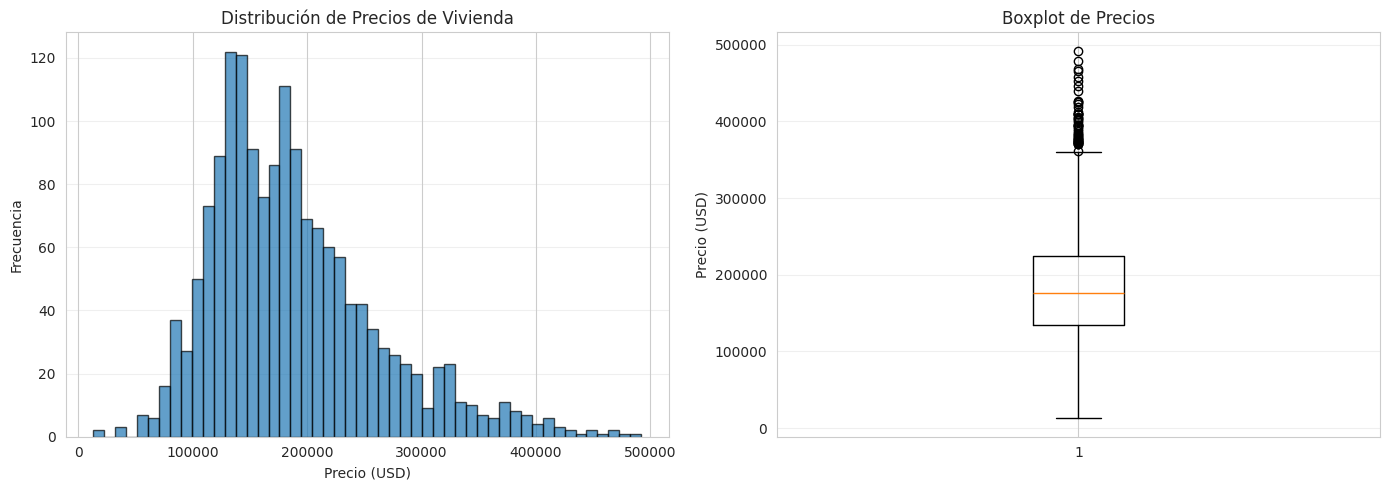

ESTADÍSTICAS DE LA VARIABLE OBJETIVO:
count      1612.000000
mean     187497.690447
std       73383.230469
min       12789.000000
25%      135000.000000
50%      175700.000000
75%      225000.000000
max      492000.000000
Name: Price (USD), dtype: float64


In [ ]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean['Price (USD)'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios de Vivienda')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['Price (USD)'])
plt.ylabel('Precio (USD)')
plt.title('Boxplot de Precios')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('distribucion_precio.png', dpi=300, bbox_inches='tight')
plt.show()

print("ESTADÍSTICAS DE LA VARIABLE OBJETIVO:")
print(df_clean['Price (USD)'].describe())


#EDA - Matriz de Correlación

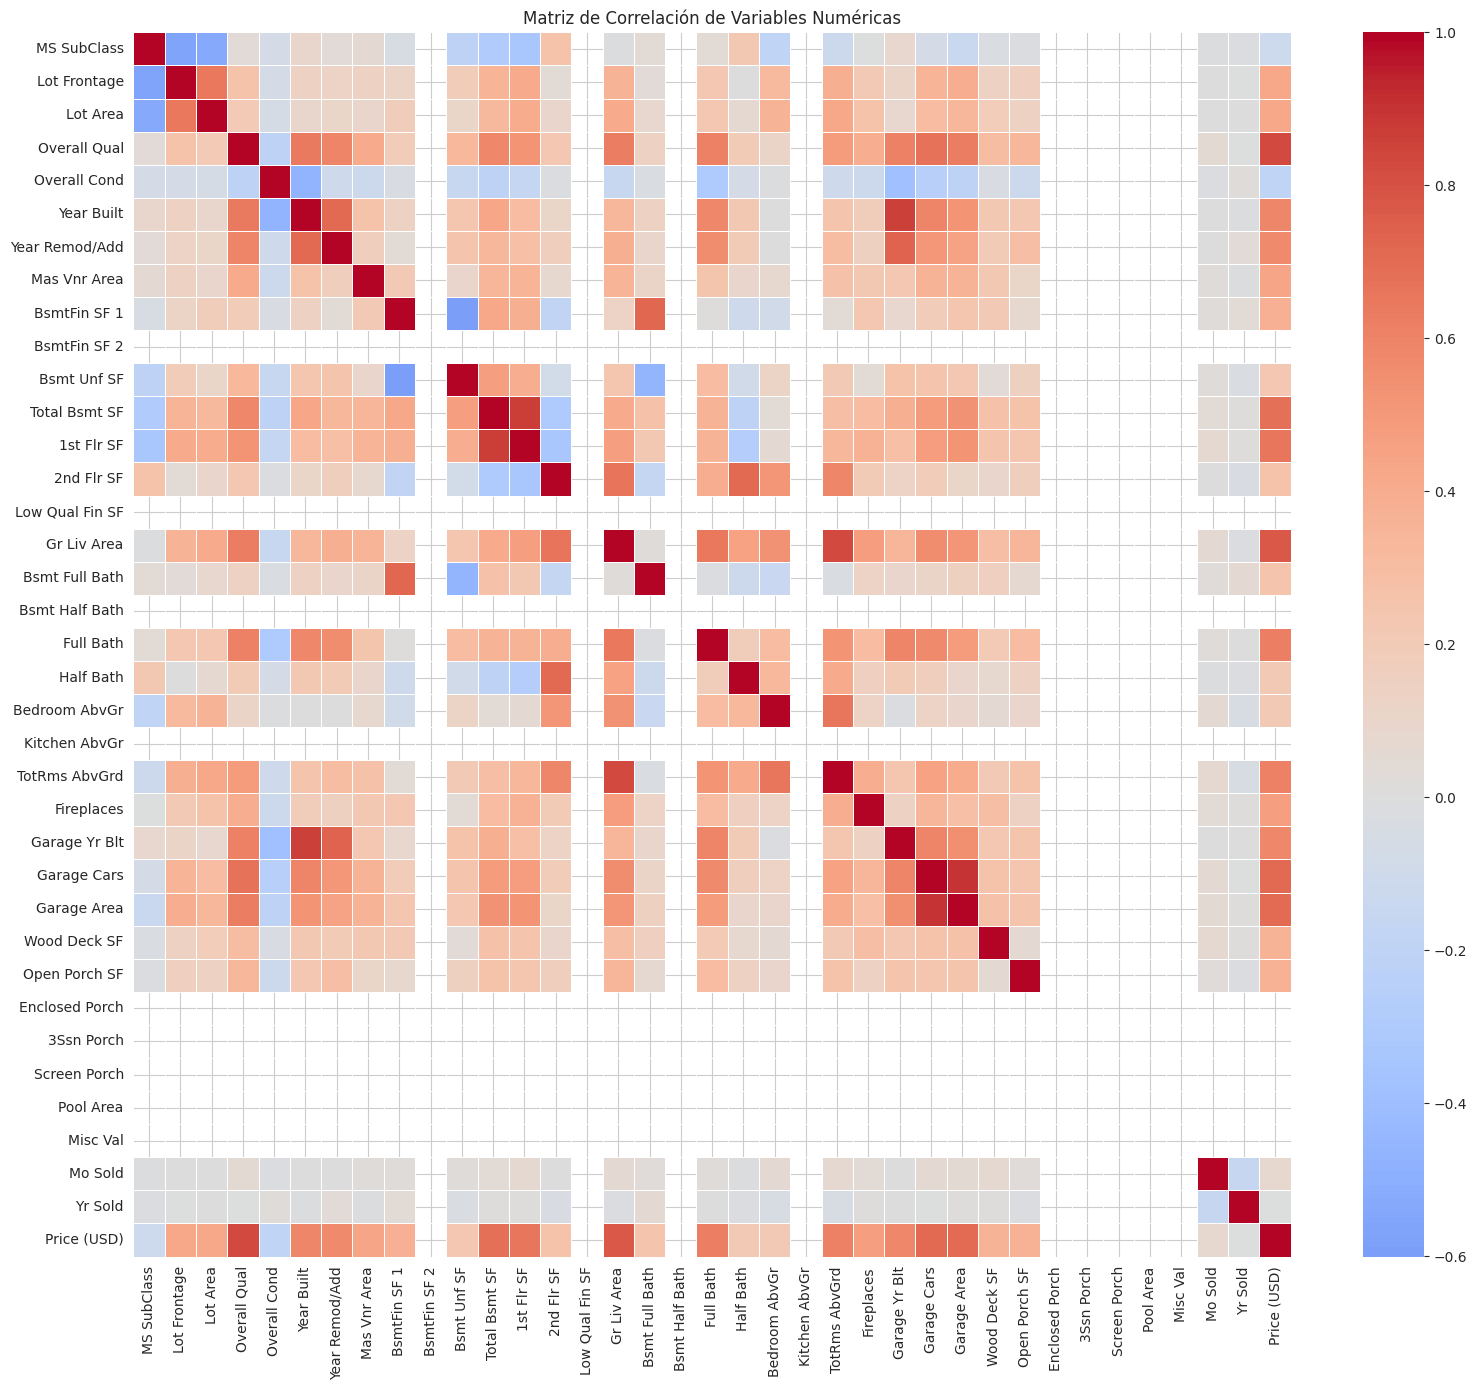

TOP 15 CORRELACIONES CON PRECIO:
Price (USD)       1.000000
Overall Qual      0.826496
Gr Liv Area       0.771222
Garage Cars       0.717165
Garage Area       0.706007
Total Bsmt SF     0.678661
1st Flr SF        0.660564
Full Bath         0.619504
TotRms AbvGrd     0.616017
Year Built        0.591023
Garage Yr Blt     0.576297
Year Remod/Add    0.571114
Fireplaces        0.473808
Mas Vnr Area      0.442764
Lot Frontage      0.428209
Name: Price (USD), dtype: float64


In [ ]:
columnas_numericas_corr = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

if 'Order' in columnas_numericas_corr:
    columnas_numericas_corr.remove('Order')
if 'PID' in columnas_numericas_corr:
    columnas_numericas_corr.remove('PID')

correlacion = df_clean[columnas_numericas_corr].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlacion, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

correlacion_precio = correlacion['Price (USD)'].sort_values(ascending=False)
print("TOP 15 CORRELACIONES CON PRECIO:")
print(correlacion_precio.head(15))


#Codificación de Variables Categóricas

In [ ]:


df_encoded = df_clean.copy()

columnas_categoricas_encode = df_encoded.select_dtypes(include=['object']).columns.tolist()

print(f"Variables categóricas a codificar: {len(columnas_categoricas_encode)}")
print(columnas_categoricas_encode)
print("\n")

label_encoders = {}

for col in columnas_categoricas_encode:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"Codificada: {col}")

print("\n")
print(f"Dimensiones después de codificación: {df_encoded.shape}")

Variables categóricas a codificar: 38
['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Sale Type', 'Sale Condition']


Codificada: MS Zoning
Codificada: Street
Codificada: Lot Shape
Codificada: Land Contour
Codificada: Utilities
Codificada: Lot Config
Codificada: Land Slope
Codificada: Neighborhood
Codificada: Condition 1
Codificada: Condition 2
Codificada: Bldg Type
Codificada: House Style
Codificada: Roof Style
Codificada: Roof Matl
Codificada: Exterior 1st
Codificada: Exterior 2nd
Codificada: Exter Qual
Codificada:

#Análisis de Multicolinealidad (VIF)

In [ ]:

X_vif = df_encoded.drop(columns=['Price (USD)', 'Order', 'PID'])

vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data = vif_data.sort_values('VIF', ascending=False)

print("FACTOR DE INFLACIÓN DE VARIANZA (VIF)")
print("="*60)
print(vif_data.head(20))
print("\n")

columnas_alto_vif = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
print(f"Variables con VIF > 10: {len(columnas_alto_vif)}")
print(columnas_alto_vif)

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


FACTOR DE INFLACIÓN DE VARIANZA (VIF)
          Variable           VIF
40      1st Flr SF           inf
43     Gr Liv Area           inf
41      2nd Flr SF           inf
49   Kitchen AbvGr  2.588359e+06
34     Bsmt Unf SF  1.464507e+04
31    BsmtFin SF 1  1.384390e+04
35   Total Bsmt SF  1.136207e+04
17      Year Built  9.637493e+00
58     Garage Cars  7.287575e+00
0      MS SubClass  7.010890e+00
13       Bldg Type  6.795842e+00
59     Garage Area  6.539045e+00
22    Exterior 2nd  6.505304e+00
21    Exterior 1st  6.236569e+00
56   Garage Yr Blt  5.939737e+00
51   TotRms AbvGrd  4.593410e+00
15    Overall Qual  4.292377e+00
18  Year Remod/Add  3.684932e+00
46       Full Bath  3.331503e+00
24      Exter Qual  2.982342e+00


Variables con VIF > 10: 7
['1st Flr SF', 'Gr Liv Area', '2nd Flr SF', 'Kitchen AbvGr', 'Bsmt Unf SF', 'BsmtFin SF 1', 'Total Bsmt SF']


#Selección de Características

In [ ]:
columnas_eliminar_adicionales = ['Order', 'PID']

if len(columnas_alto_vif) > 0:
    columnas_eliminar_adicionales.extend(columnas_alto_vif)

columnas_eliminar_adicionales = list(set(columnas_eliminar_adicionales))

X = df_encoded.drop(columns=['Price (USD)'] + columnas_eliminar_adicionales)
y = df_encoded['Price (USD)']

print(f"Características seleccionadas: {X.shape[1]}")
print(f"Variables eliminadas: {len(columnas_eliminar_adicionales)}")
print("\n")
print("Columnas eliminadas:")
print(columnas_eliminar_adicionales)


Características seleccionadas: 67
Variables eliminadas: 9


Columnas eliminadas:
['Gr Liv Area', 'Kitchen AbvGr', 'BsmtFin SF 1', 'PID', 'Bsmt Unf SF', '2nd Flr SF', 'Order', 'Total Bsmt SF', '1st Flr SF']


#División del Dataset (80-20)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("DIVISIÓN DEL DATASET")
print("="*60)
print(f"Total de instancias: {len(X)}")
print(f"Conjunto de entrenamiento: {len(X_train)} ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Conjunto de prueba: {len(X_test)} ({(len(X_test)/len(X))*100:.1f}%)")
print("\n")
print(f"Características: {X_train.shape[1]}")


DIVISIÓN DEL DATASET
Total de instancias: 1612
Conjunto de entrenamiento: 1289 (80.0%)
Conjunto de prueba: 323 (20.0%)


Características: 67


#Normalización de Datos

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("NORMALIZACIÓN COMPLETADA")
print("="*60)
print(f"Media de características de entrenamiento (primeras 5):")
print(X_train_scaled[:, :5].mean(axis=0))
print("\n")
print(f"Desviación estándar de características de entrenamiento (primeras 5):")
print(X_train_scaled[:, :5].std(axis=0))


NORMALIZACIÓN COMPLETADA
Media de características de entrenamiento (primeras 5):
[ 1.10247127e-16 -1.47455533e-16 -8.26853455e-17  2.14981898e-16
 -2.41165591e-16]


Desviación estándar de características de entrenamiento (primeras 5):
[1. 1. 1. 1. 1.]


#Modelo 1 - Regresión Lineal

MODELO 1: REGRESIÓN LINEAL
R² Entrenamiento: 0.8936
R² Prueba: 0.8727
RMSE Entrenamiento: 23854.94
RMSE Prueba: 26425.69
MSE Prueba: 698317318.01
Validación Cruzada R² (promedio): 0.8799 (+/- 0.0096)


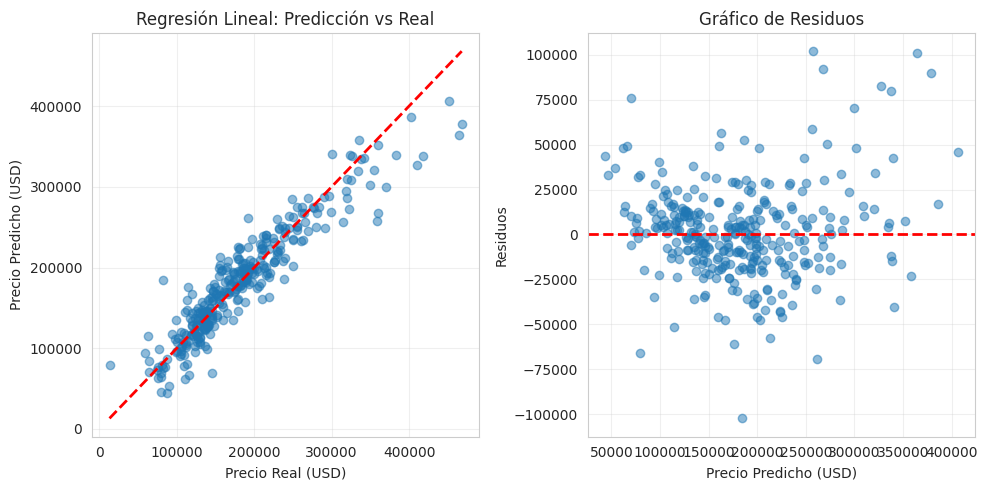

In [ ]:
print("MODELO 1: REGRESIÓN LINEAL")
print("="*60)

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

r2_train_lr = r2_score(y_train, y_pred_lr_train)
r2_test_lr = r2_score(y_test, y_pred_lr_test)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr_train))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr_test))
mse_test_lr = mean_squared_error(y_test, y_pred_lr_test)

cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_lr:.4f}")
print(f"R² Prueba: {r2_test_lr:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_lr:.2f}")
print(f"RMSE Prueba: {rmse_test_lr:.2f}")
print(f"MSE Prueba: {mse_test_lr:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_lr.mean():.4f} (+/- {cv_scores_lr.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Lineal: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_lr_test
plt.scatter(y_pred_lr_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo1_regresion_lineal.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 2 - Regresión Ridge

MODELO 2: REGRESIÓN RIDGE
Mejor alpha: 100.0
R² Entrenamiento: 0.8924
R² Prueba: 0.8695
RMSE Entrenamiento: 23989.73
RMSE Prueba: 26755.45
MSE Prueba: 715854184.30
Validación Cruzada R² (promedio): 0.8809 (+/- 0.0121)


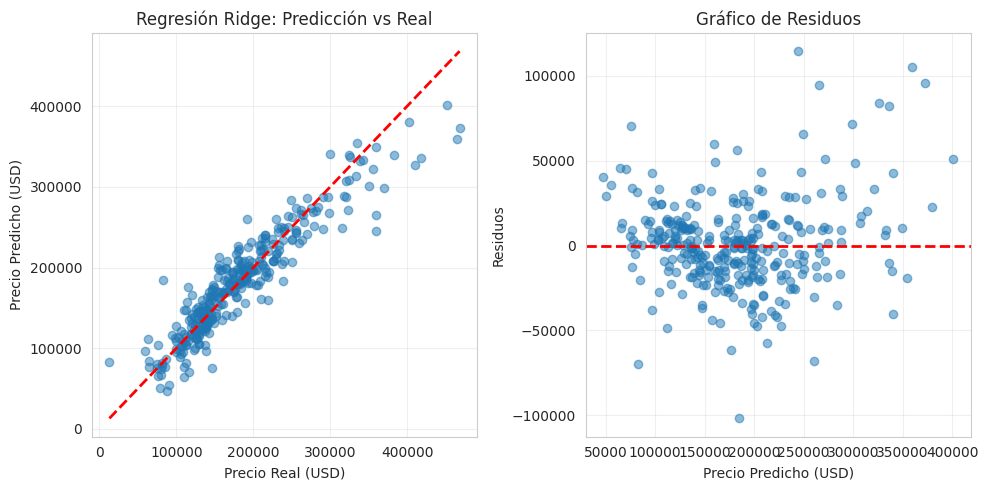

In [ ]:
print("MODELO 2: REGRESIÓN RIDGE")
print("="*60)

param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_model = Ridge()
grid_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5, scoring='r2', n_jobs=-1)
grid_ridge.fit(X_train_scaled, y_train)

best_ridge = grid_ridge.best_estimator_
print(f"Mejor alpha: {grid_ridge.best_params_['alpha']}")

y_pred_ridge_train = best_ridge.predict(X_train_scaled)
y_pred_ridge_test = best_ridge.predict(X_test_scaled)

r2_train_ridge = r2_score(y_train, y_pred_ridge_train)
r2_test_ridge = r2_score(y_test, y_pred_ridge_test)
rmse_train_ridge = np.sqrt(mean_squared_error(y_train, y_pred_ridge_train))
rmse_test_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge_test))
mse_test_ridge = mean_squared_error(y_test, y_pred_ridge_test)

cv_scores_ridge = cross_val_score(best_ridge, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_ridge:.4f}")
print(f"R² Prueba: {r2_test_ridge:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_ridge:.2f}")
print(f"RMSE Prueba: {rmse_test_ridge:.2f}")
print(f"MSE Prueba: {mse_test_ridge:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_ridge.mean():.4f} (+/- {cv_scores_ridge.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Ridge: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_ridge_test
plt.scatter(y_pred_ridge_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo2_regresion_ridge.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 3 - Regresión Lasso

MODELO 3: REGRESIÓN LASSO
Mejor alpha: 100.0
R² Entrenamiento: 0.8934
R² Prueba: 0.8729
RMSE Entrenamiento: 23872.72
RMSE Prueba: 26411.20
MSE Prueba: 697551492.99
Validación Cruzada R² (promedio): 0.8810 (+/- 0.0096)


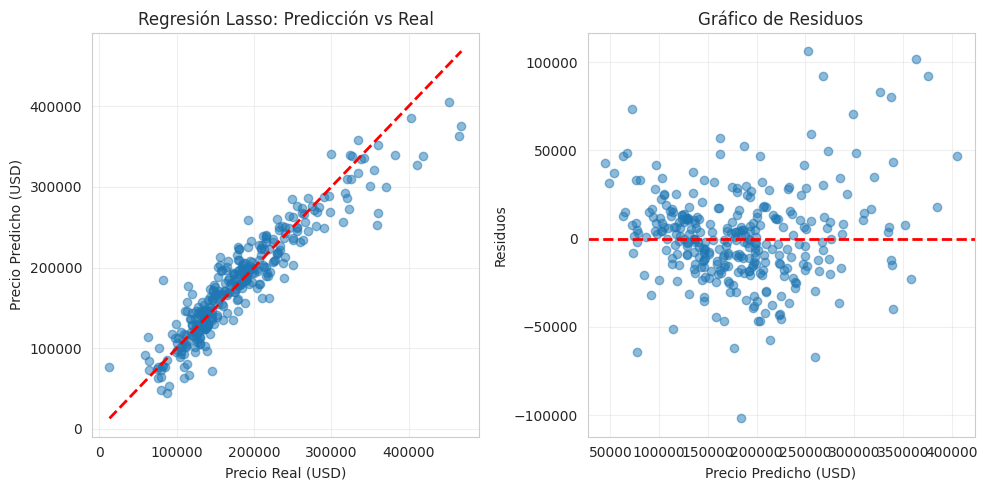

In [ ]:
print("MODELO 3: REGRESIÓN LASSO")
print("="*60)

param_grid_lasso = {'alpha': [0.1, 1.0, 10.0, 100.0]}

lasso_model = Lasso()
grid_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, scoring='r2', n_jobs=-1)
grid_lasso.fit(X_train_scaled, y_train)

best_lasso = grid_lasso.best_estimator_
print(f"Mejor alpha: {grid_lasso.best_params_['alpha']}")

y_pred_lasso_train = best_lasso.predict(X_train_scaled)
y_pred_lasso_test = best_lasso.predict(X_test_scaled)

r2_train_lasso = r2_score(y_train, y_pred_lasso_train)
r2_test_lasso = r2_score(y_test, y_pred_lasso_test)
rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_pred_lasso_train))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso_test))
mse_test_lasso = mean_squared_error(y_test, y_pred_lasso_test)

cv_scores_lasso = cross_val_score(best_lasso, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_lasso:.4f}")
print(f"R² Prueba: {r2_test_lasso:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_lasso:.2f}")
print(f"RMSE Prueba: {rmse_test_lasso:.2f}")
print(f"MSE Prueba: {mse_test_lasso:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_lasso.mean():.4f} (+/- {cv_scores_lasso.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Lasso: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_lasso_test
plt.scatter(y_pred_lasso_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo3_regresion_lasso.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 4 - Árbol de Decisión

MODELO 4: ÁRBOL DE DECISIÓN
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 2}
R² Entrenamiento: 0.8655
R² Prueba: 0.7551
RMSE Entrenamiento: 26814.75
RMSE Prueba: 36658.03
MSE Prueba: 1343811224.44
Validación Cruzada R² (promedio): 0.7785 (+/- 0.0341)


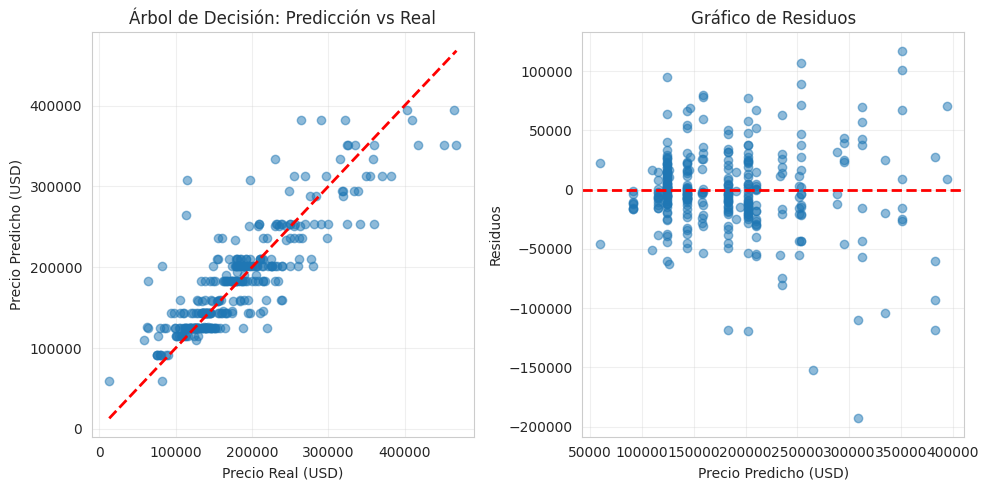

In [ ]:
print("MODELO 4: ÁRBOL DE DECISIÓN")
print("="*60)

param_grid_dt = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

dt_model = DecisionTreeRegressor(random_state=42)
grid_dt = GridSearchCV(dt_model, param_grid_dt, cv=5, scoring='r2', n_jobs=-1)
grid_dt.fit(X_train_scaled, y_train)

best_dt = grid_dt.best_estimator_
print(f"Mejores parámetros: {grid_dt.best_params_}")

y_pred_dt_train = best_dt.predict(X_train_scaled)
y_pred_dt_test = best_dt.predict(X_test_scaled)

r2_train_dt = r2_score(y_train, y_pred_dt_train)
r2_test_dt = r2_score(y_test, y_pred_dt_test)
rmse_train_dt = np.sqrt(mean_squared_error(y_train, y_pred_dt_train))
rmse_test_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt_test))
mse_test_dt = mean_squared_error(y_test, y_pred_dt_test)

cv_scores_dt = cross_val_score(best_dt, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_dt:.4f}")
print(f"R² Prueba: {r2_test_dt:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_dt:.2f}")
print(f"RMSE Prueba: {rmse_test_dt:.2f}")
print(f"MSE Prueba: {mse_test_dt:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_dt.mean():.4f} (+/- {cv_scores_dt.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_dt_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Árbol de Decisión: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_dt_test
plt.scatter(y_pred_dt_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo4_arbol_decision.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 5 - Random Forest

MODELO 5: RANDOM FOREST
Mejores parámetros: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 200}
R² Entrenamiento: 0.9824
R² Prueba: 0.8682
RMSE Entrenamiento: 9703.47
RMSE Prueba: 26891.93
MSE Prueba: 723176051.25
Validación Cruzada R² (promedio): 0.8707 (+/- 0.0167)


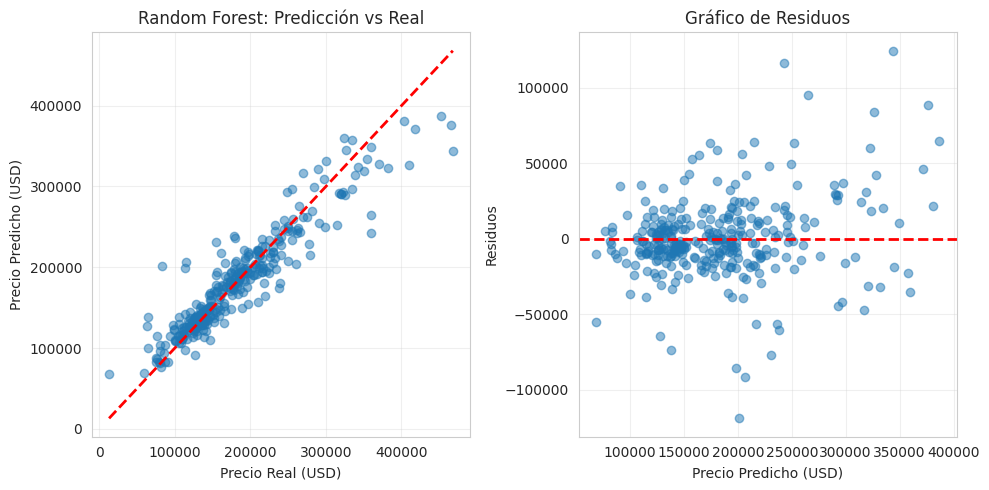

In [ ]:
print("MODELO 5: RANDOM FOREST")
print("="*60)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

rf_model = RandomForestRegressor(random_state=42)
grid_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
print(f"Mejores parámetros: {grid_rf.best_params_}")

y_pred_rf_train = best_rf.predict(X_train_scaled)
y_pred_rf_test = best_rf.predict(X_test_scaled)

r2_train_rf = r2_score(y_train, y_pred_rf_train)
r2_test_rf = r2_score(y_test, y_pred_rf_test)
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf_train))
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))
mse_test_rf = mean_squared_error(y_test, y_pred_rf_test)

cv_scores_rf = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_rf:.4f}")
print(f"R² Prueba: {r2_test_rf:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_rf:.2f}")
print(f"RMSE Prueba: {rmse_test_rf:.2f}")
print(f"MSE Prueba: {mse_test_rf:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Random Forest: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_rf_test
plt.scatter(y_pred_rf_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo5_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 6 - Gradient Boosting

MODELO 6: GRADIENT BOOSTING
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
R² Entrenamiento: 0.9709
R² Prueba: 0.8921
RMSE Entrenamiento: 12468.52
RMSE Prueba: 24327.37
MSE Prueba: 591820768.67
Validación Cruzada R² (promedio): 0.8956 (+/- 0.0208)


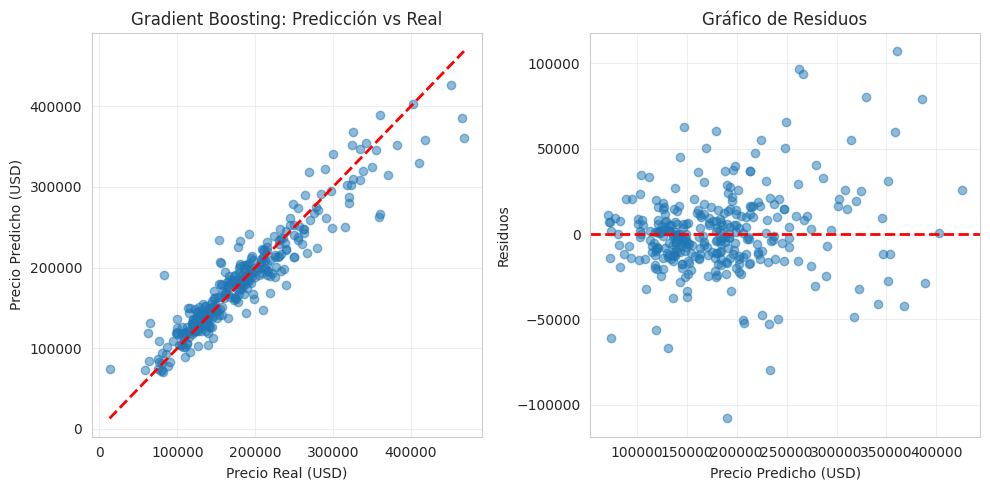

In [ ]:
print("MODELO 6: GRADIENT BOOSTING")
print("="*60)

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_gb = GridSearchCV(gb_model, param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)

best_gb = grid_gb.best_estimator_
print(f"Mejores parámetros: {grid_gb.best_params_}")

y_pred_gb_train = best_gb.predict(X_train_scaled)
y_pred_gb_test = best_gb.predict(X_test_scaled)

r2_train_gb = r2_score(y_train, y_pred_gb_train)
r2_test_gb = r2_score(y_test, y_pred_gb_test)
rmse_train_gb = np.sqrt(mean_squared_error(y_train, y_pred_gb_train))
rmse_test_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb_test))
mse_test_gb = mean_squared_error(y_test, y_pred_gb_test)

cv_scores_gb = cross_val_score(best_gb, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_gb:.4f}")
print(f"R² Prueba: {r2_test_gb:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_gb:.2f}")
print(f"RMSE Prueba: {rmse_test_gb:.2f}")
print(f"MSE Prueba: {mse_test_gb:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_gb.mean():.4f} (+/- {cv_scores_gb.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Gradient Boosting: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_gb_test
plt.scatter(y_pred_gb_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo6_gradient_boosting.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 7 - AdaBoost Regressor

MODELO 7: ADABOOST REGRESSOR
Mejores parámetros: {'learning_rate': 0.5, 'n_estimators': 50}
R² Entrenamiento: 0.8700
R² Prueba: 0.8164
RMSE Entrenamiento: 26363.84
RMSE Prueba: 31737.54
MSE Prueba: 1007271571.47
Validación Cruzada R² (promedio): 0.8292 (+/- 0.0192)


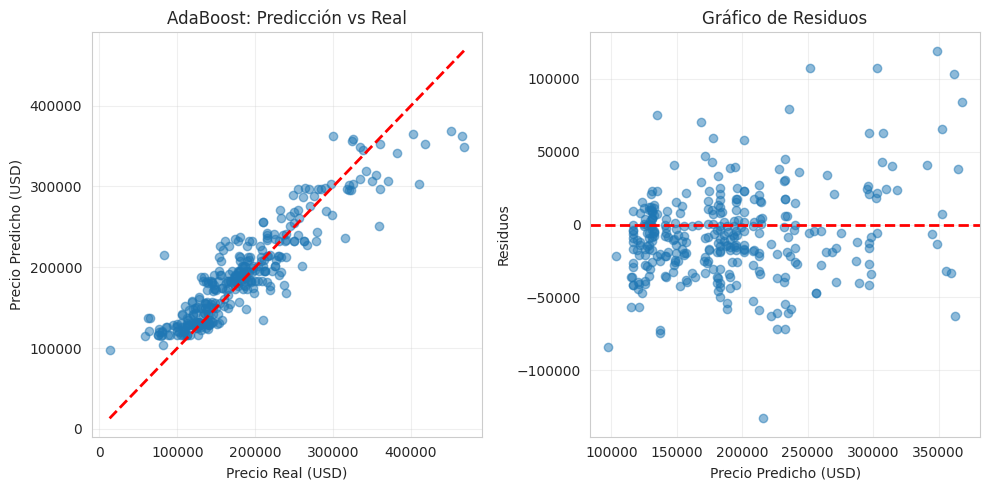

In [ ]:
print("MODELO 7: ADABOOST REGRESSOR")
print("="*60)

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_model = AdaBoostRegressor(random_state=42)
grid_ada = GridSearchCV(ada_model, param_grid_ada, cv=5, scoring='r2', n_jobs=-1)
grid_ada.fit(X_train_scaled, y_train)

best_ada = grid_ada.best_estimator_
print(f"Mejores parámetros: {grid_ada.best_params_}")

y_pred_ada_train = best_ada.predict(X_train_scaled)
y_pred_ada_test = best_ada.predict(X_test_scaled)

r2_train_ada = r2_score(y_train, y_pred_ada_train)
r2_test_ada = r2_score(y_test, y_pred_ada_test)
rmse_train_ada = np.sqrt(mean_squared_error(y_train, y_pred_ada_train))
rmse_test_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada_test))
mse_test_ada = mean_squared_error(y_test, y_pred_ada_test)

cv_scores_ada = cross_val_score(best_ada, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_ada:.4f}")
print(f"R² Prueba: {r2_test_ada:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_ada:.2f}")
print(f"RMSE Prueba: {rmse_test_ada:.2f}")
print(f"MSE Prueba: {mse_test_ada:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_ada.mean():.4f} (+/- {cv_scores_ada.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ada_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('AdaBoost: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_ada_test
plt.scatter(y_pred_ada_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo7_adaboost.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 8 - Support Vector Machine (SVR)

MODELO 8: SUPPORT VECTOR MACHINE (SVR)
Mejores parámetros: {'C': 100, 'epsilon': 0.2, 'kernel': 'linear'}
R² Entrenamiento: 0.8719
R² Prueba: 0.8418
RMSE Entrenamiento: 26171.28
RMSE Prueba: 29464.63
MSE Prueba: 868164505.76
Validación Cruzada R² (promedio): 0.8629 (+/- 0.0186)


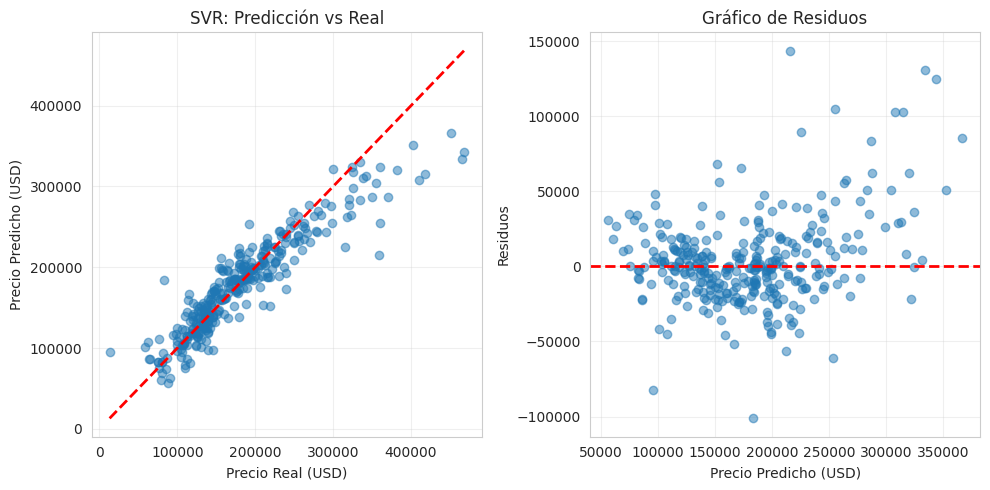

In [ ]:
print("MODELO 8: SUPPORT VECTOR MACHINE (SVR)")
print("="*60)

param_grid_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

svr_model = SVR()
grid_svr = GridSearchCV(svr_model, param_grid_svr, cv=5, scoring='r2', n_jobs=-1)
grid_svr.fit(X_train_scaled, y_train)

best_svr = grid_svr.best_estimator_
print(f"Mejores parámetros: {grid_svr.best_params_}")

y_pred_svr_train = best_svr.predict(X_train_scaled)
y_pred_svr_test = best_svr.predict(X_test_scaled)

r2_train_svr = r2_score(y_train, y_pred_svr_train)
r2_test_svr = r2_score(y_test, y_pred_svr_test)
rmse_train_svr = np.sqrt(mean_squared_error(y_train, y_pred_svr_train))
rmse_test_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr_test))
mse_test_svr = mean_squared_error(y_test, y_pred_svr_test)

cv_scores_svr = cross_val_score(best_svr, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_svr:.4f}")
print(f"R² Prueba: {r2_test_svr:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_svr:.2f}")
print(f"RMSE Prueba: {rmse_test_svr:.2f}")
print(f"MSE Prueba: {mse_test_svr:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_svr.mean():.4f} (+/- {cv_scores_svr.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_svr_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('SVR: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_svr_test
plt.scatter(y_pred_svr_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo8_svr.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 9 - MLP Regressor

MODELO 9: MLP REGRESSOR (RED NEURONAL)
Mejores parámetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
R² Entrenamiento: 0.8753
R² Prueba: 0.6250
RMSE Entrenamiento: 25827.46
RMSE Prueba: 45358.17
MSE Prueba: 2057363830.79
Validación Cruzada R² (promedio): 0.7644 (+/- 0.0086)


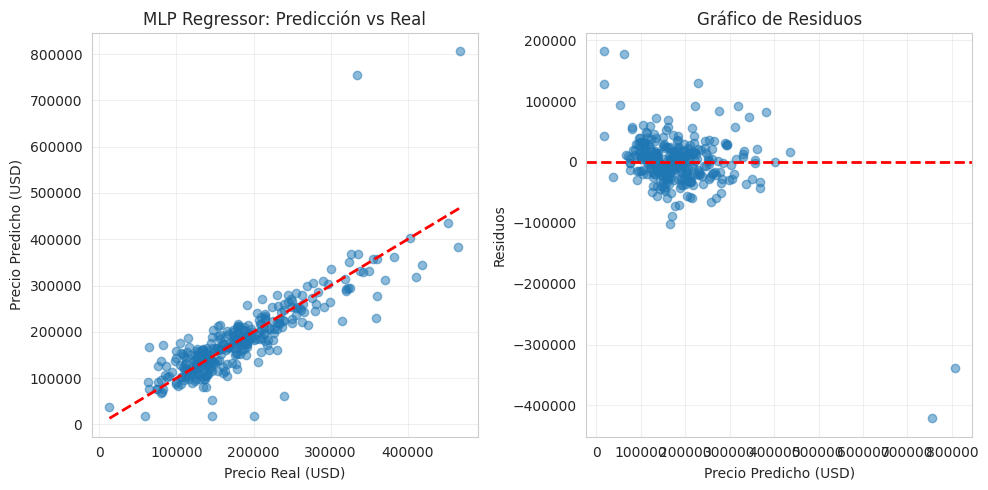

In [ ]:
print("MODELO 9: MLP REGRESSOR (RED NEURONAL)")
print("="*60)

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp_model = MLPRegressor(max_iter=1000, random_state=42)
grid_mlp = GridSearchCV(mlp_model, param_grid_mlp, cv=5, scoring='r2', n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

best_mlp = grid_mlp.best_estimator_
print(f"Mejores parámetros: {grid_mlp.best_params_}")

y_pred_mlp_train = best_mlp.predict(X_train_scaled)
y_pred_mlp_test = best_mlp.predict(X_test_scaled)

r2_train_mlp = r2_score(y_train, y_pred_mlp_train)
r2_test_mlp = r2_score(y_test, y_pred_mlp_test)
rmse_train_mlp = np.sqrt(mean_squared_error(y_train, y_pred_mlp_train))
rmse_test_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp_test))
mse_test_mlp = mean_squared_error(y_test, y_pred_mlp_test)

cv_scores_mlp = cross_val_score(best_mlp, X_train_scaled, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_mlp:.4f}")
print(f"R² Prueba: {r2_test_mlp:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_mlp:.2f}")
print(f"RMSE Prueba: {rmse_test_mlp:.2f}")
print(f"MSE Prueba: {mse_test_mlp:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_mlp.mean():.4f} (+/- {cv_scores_mlp.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_mlp_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('MLP Regressor: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_mlp_test
plt.scatter(y_pred_mlp_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo9_mlp_regressor.png', dpi=300, bbox_inches='tight')
plt.show()


# Tabla Comparativa de Todos los Modelos


In [ ]:
resultados = {
    'Modelo': [
        'Regresión Lineal',
        'Regresión Ridge',
        'Regresión Lasso',
        'Árbol de Decisión',
        'Random Forest',
        'Gradient Boosting',
        'AdaBoost',
        'SVR',
        'MLP Regressor'
    ],
    'R² Entrenamiento': [
        r2_train_lr, r2_train_ridge, r2_train_lasso,
        r2_train_dt, r2_train_rf, r2_train_gb,
        r2_train_ada, r2_train_svr, r2_train_mlp
    ],
    'R² Prueba': [
        r2_test_lr, r2_test_ridge, r2_test_lasso,
        r2_test_dt, r2_test_rf, r2_test_gb,
        r2_test_ada, r2_test_svr, r2_test_mlp
    ],
    'RMSE Entrenamiento': [
        rmse_train_lr, rmse_train_ridge, rmse_train_lasso,
        rmse_train_dt, rmse_train_rf, rmse_train_gb,
        rmse_train_ada, rmse_train_svr, rmse_train_mlp
    ],
    'RMSE Prueba': [
        rmse_test_lr, rmse_test_ridge, rmse_test_lasso,
        rmse_test_dt, rmse_test_rf, rmse_test_gb,
        rmse_test_ada, rmse_test_svr, rmse_test_mlp
    ],
    'MSE Prueba': [
        mse_test_lr, mse_test_ridge, mse_test_lasso,
        mse_test_dt, mse_test_rf, mse_test_gb,
        mse_test_ada, mse_test_svr, mse_test_mlp
    ],
    'CV R² Promedio': [
        cv_scores_lr.mean(), cv_scores_ridge.mean(), cv_scores_lasso.mean(),
        cv_scores_dt.mean(), cv_scores_rf.mean(), cv_scores_gb.mean(),
        cv_scores_ada.mean(), cv_scores_svr.mean(), cv_scores_mlp.mean()
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('R² Prueba', ascending=False)

print("TABLA COMPARATIVA DE DESEMPEÑO DE MODELOS")
print("="*100)
print(df_resultados.to_string(index=False))

df_resultados.to_csv('resultados_modelos.csv', index=False)
print("\nTabla guardada como: resultados_modelos.csv")


TABLA COMPARATIVA DE DESEMPEÑO DE MODELOS
           Modelo  R² Entrenamiento  R² Prueba  RMSE Entrenamiento  RMSE Prueba   MSE Prueba  CV R² Promedio
Gradient Boosting          0.970928   0.892138        12468.518734 24327.366661 5.918208e+08        0.895572
  Regresión Lasso          0.893425   0.872868        23872.720890 26411.200143 6.975515e+08        0.881001
 Regresión Lineal          0.893584   0.872728        23854.937579 26425.694277 6.983173e+08        0.879877
  Regresión Ridge          0.892378   0.869532        23989.729819 26755.451488 7.158542e+08        0.880872
    Random Forest          0.982392   0.868198         9703.467666 26891.932828 7.231761e+08        0.870745
              SVR          0.871914   0.841773        26171.281029 29464.631438 8.681645e+08        0.862890
         AdaBoost          0.870023   0.816420        26363.841180 31737.541988 1.007272e+09        0.829194
Árbol de Decisión          0.865539   0.755084        26814.746152 36658.030832 1.3438

#Gráficas de Comparación de Modelos

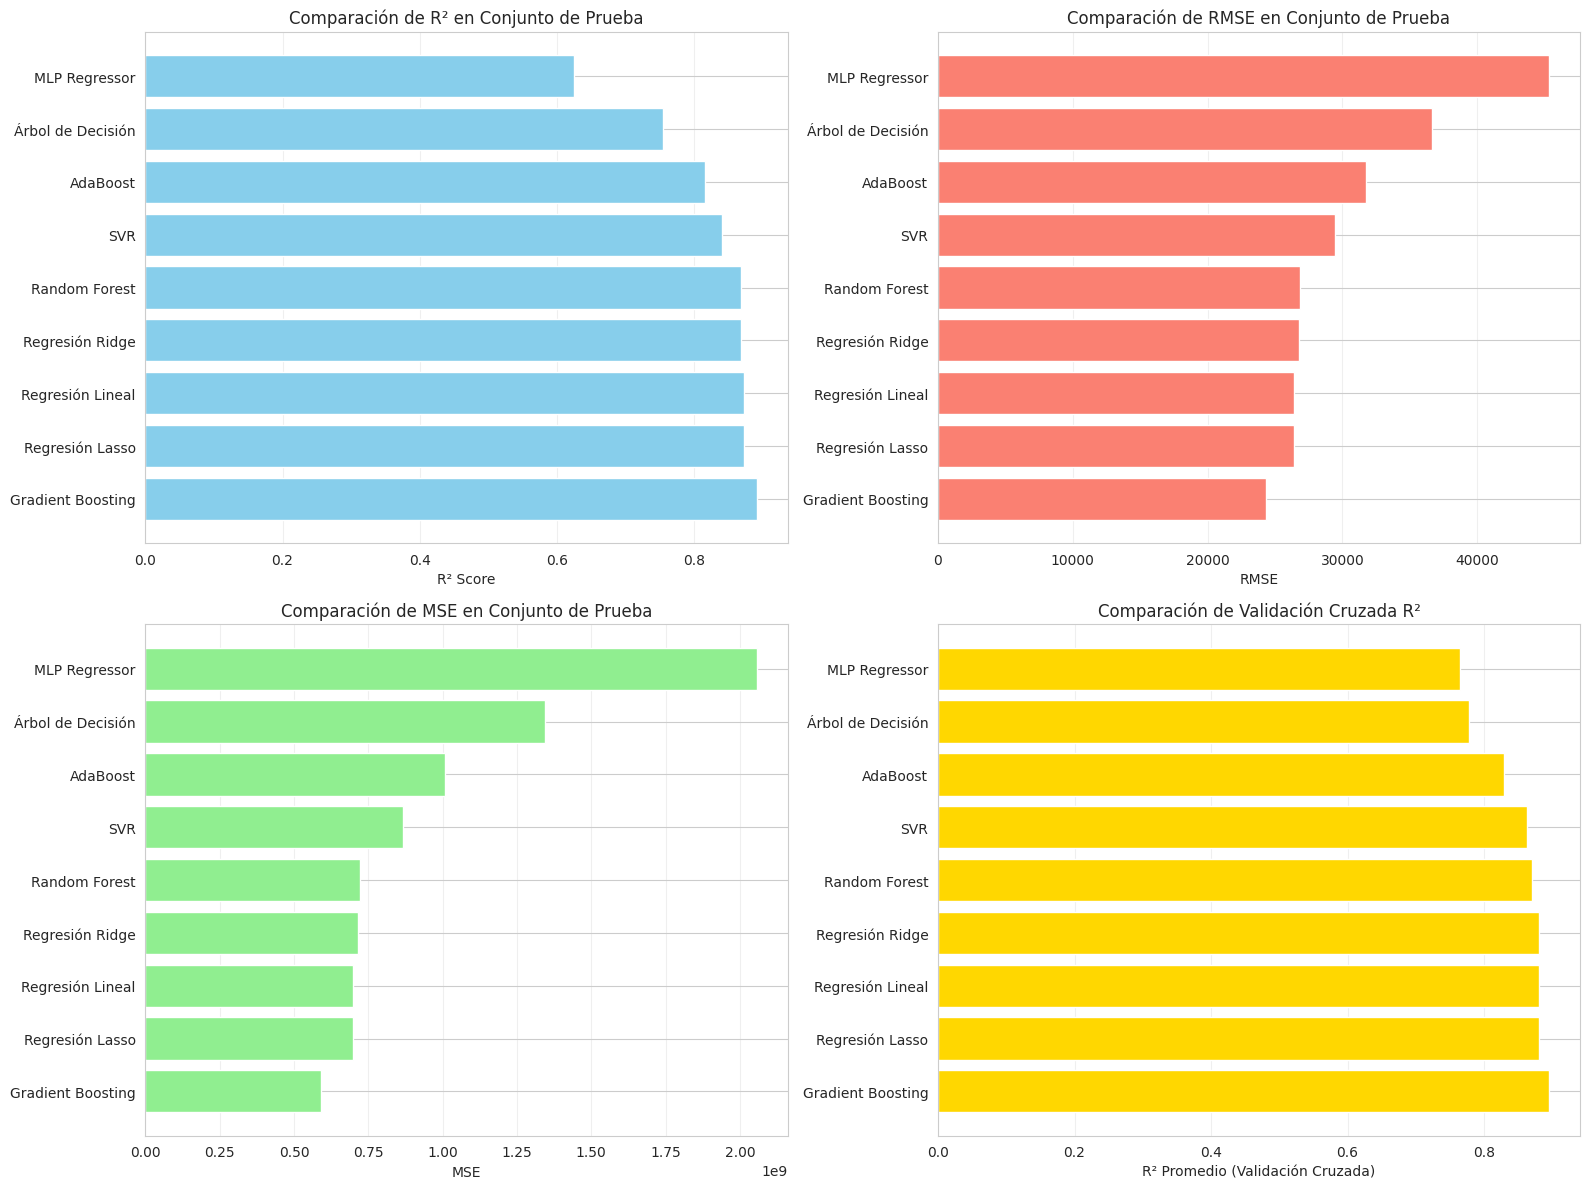

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

modelos = df_resultados['Modelo'].tolist()
r2_prueba = df_resultados['R² Prueba'].tolist()
rmse_prueba = df_resultados['RMSE Prueba'].tolist()
mse_prueba = df_resultados['MSE Prueba'].tolist()
cv_r2 = df_resultados['CV R² Promedio'].tolist()

axes[0, 0].barh(modelos, r2_prueba, color='skyblue')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Comparación de R² en Conjunto de Prueba')
axes[0, 0].grid(axis='x', alpha=0.3)

axes[0, 1].barh(modelos, rmse_prueba, color='salmon')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Comparación de RMSE en Conjunto de Prueba')
axes[0, 1].grid(axis='x', alpha=0.3)

axes[1, 0].barh(modelos, mse_prueba, color='lightgreen')
axes[1, 0].set_xlabel('MSE')
axes[1, 0].set_title('Comparación de MSE en Conjunto de Prueba')
axes[1, 0].grid(axis='x', alpha=0.3)

axes[1, 1].barh(modelos, cv_r2, color='gold')
axes[1, 1].set_xlabel('R² Promedio (Validación Cruzada)')
axes[1, 1].set_title('Comparación de Validación Cruzada R²')
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('comparacion_modelos.png', dpi=300, bbox_inches='tight')
plt.show()


#Gráfica de R² y RMSE Combinada

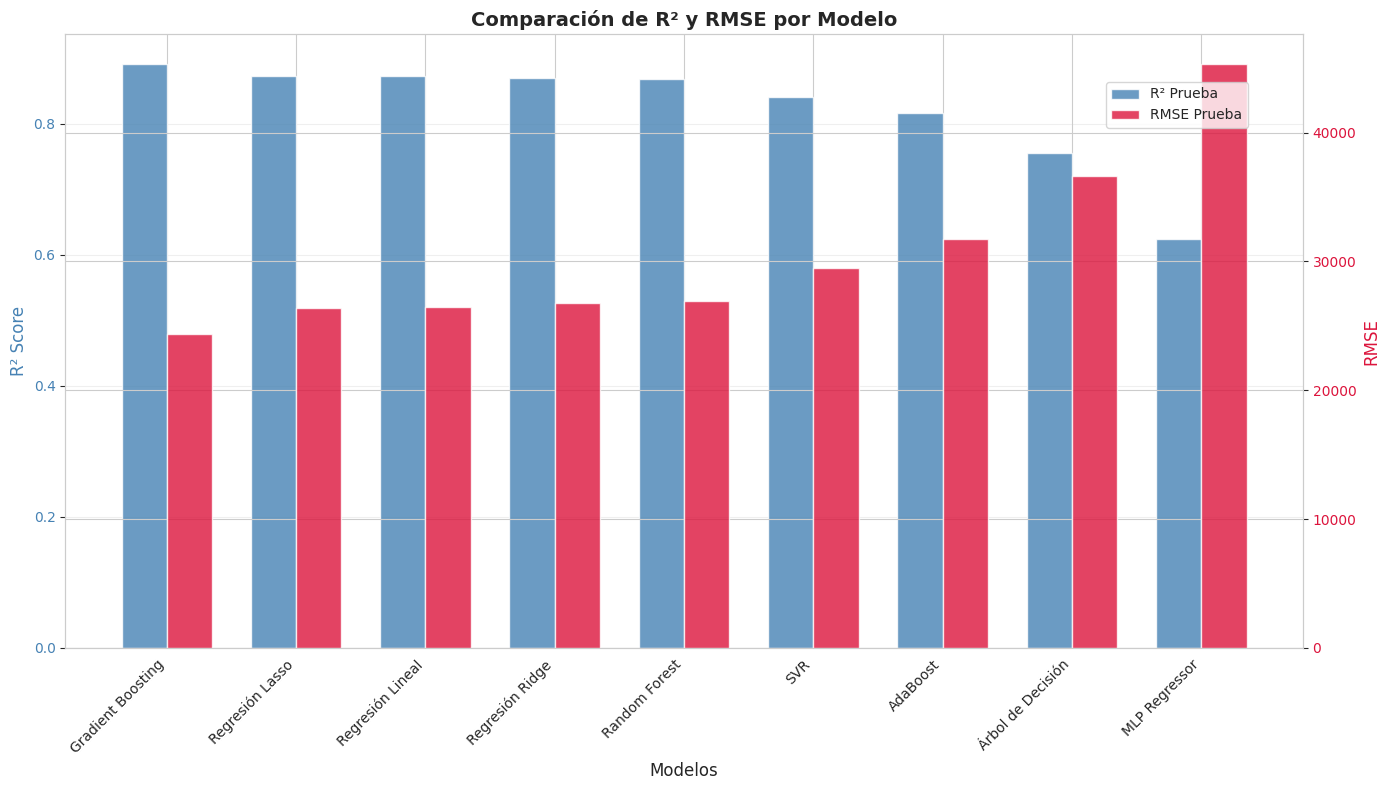

In [ ]:
fig, ax1 = plt.subplots(figsize=(14, 8))

x_pos = np.arange(len(modelos))
width = 0.35

ax1.bar(x_pos - width/2, r2_prueba, width, label='R² Prueba', color='steelblue', alpha=0.8)
ax1.set_xlabel('Modelos', fontsize=12)
ax1.set_ylabel('R² Score', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(modelos, rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

ax2 = ax1.twinx()
ax2.bar(x_pos + width/2, rmse_prueba, width, label='RMSE Prueba', color='crimson', alpha=0.8)
ax2.set_ylabel('RMSE', fontsize=12, color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Comparación de R² y RMSE por Modelo', fontsize=14, fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
plt.tight_layout()
plt.savefig('r2_rmse_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()


#Identificación del Mejor Modelo

In [ ]:
print("IDENTIFICACIÓN DEL MEJOR MODELO")
print("="*100)

mejor_modelo_idx = df_resultados['R² Prueba'].idxmax()
mejor_modelo = df_resultados.loc[mejor_modelo_idx]

print("\nMODELO CON MEJOR DESEMPEÑO:")
print(f"Nombre: {mejor_modelo['Modelo']}")
print(f"R² Prueba: {mejor_modelo['R² Prueba']:.4f}")
print(f"RMSE Prueba: {mejor_modelo['RMSE Prueba']:.2f}")
print(f"MSE Prueba: {mejor_modelo['MSE Prueba']:.2f}")
print(f"Validación Cruzada R²: {mejor_modelo['CV R² Promedio']:.4f}")

print("\n" + "="*100)
print("TOP 3 MODELOS POR R²:")
print(df_resultados[['Modelo', 'R² Prueba', 'RMSE Prueba']].head(3).to_string(index=False))


IDENTIFICACIÓN DEL MEJOR MODELO

MODELO CON MEJOR DESEMPEÑO:
Nombre: Gradient Boosting
R² Prueba: 0.8921
RMSE Prueba: 24327.37
MSE Prueba: 591820768.67
Validación Cruzada R²: 0.8956

TOP 3 MODELOS POR R²:
           Modelo  R² Prueba  RMSE Prueba
Gradient Boosting   0.892138 24327.366661
  Regresión Lasso   0.872868 26411.200143
 Regresión Lineal   0.872728 26425.694277


#PCA - Análisis Completo de Componentes

In [ ]:
from sklearn.decomposition import PCA

print("ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)")
print("="*60)

pca_full = PCA(n_components=None)
pca_full.fit(X_train_scaled)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"Número total de componentes: {len(explained_variance)}")
print(f"\nVarianza explicada por los primeros 10 componentes:")
for i in range(min(10, len(explained_variance))):
    print(f"PC{i+1}: {explained_variance[i]:.4f} ({explained_variance[i]*100:.2f}%)")

print(f"\nVarianza acumulada por los primeros 10 componentes:")
for i in range(min(10, len(cumulative_variance))):
    print(f"PC{i+1}: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:.2f}%)")

n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nComponentes necesarios para explicar 80% de varianza: {n_components_80}")
print(f"Componentes necesarios para explicar 90% de varianza: {n_components_90}")
print(f"Componentes necesarios para explicar 95% de varianza: {n_components_95}")


ANÁLISIS DE COMPONENTES PRINCIPALES (PCA)
Número total de componentes: 67

Varianza explicada por los primeros 10 componentes:
PC1: 0.1734 (17.34%)
PC2: 0.0624 (6.24%)
PC3: 0.0441 (4.41%)
PC4: 0.0384 (3.84%)
PC5: 0.0342 (3.42%)
PC6: 0.0311 (3.11%)
PC7: 0.0299 (2.99%)
PC8: 0.0257 (2.57%)
PC9: 0.0239 (2.39%)
PC10: 0.0231 (2.31%)

Varianza acumulada por los primeros 10 componentes:
PC1: 0.1734 (17.34%)
PC2: 0.2358 (23.58%)
PC3: 0.2799 (27.99%)
PC4: 0.3183 (31.83%)
PC5: 0.3525 (35.25%)
PC6: 0.3835 (38.35%)
PC7: 0.4134 (41.34%)
PC8: 0.4391 (43.91%)
PC9: 0.4629 (46.29%)
PC10: 0.4861 (48.61%)

Componentes necesarios para explicar 80% de varianza: 29
Componentes necesarios para explicar 90% de varianza: 39
Componentes necesarios para explicar 95% de varianza: 45


#Gráfica de Varianza Explicada y Varianza Acumulada

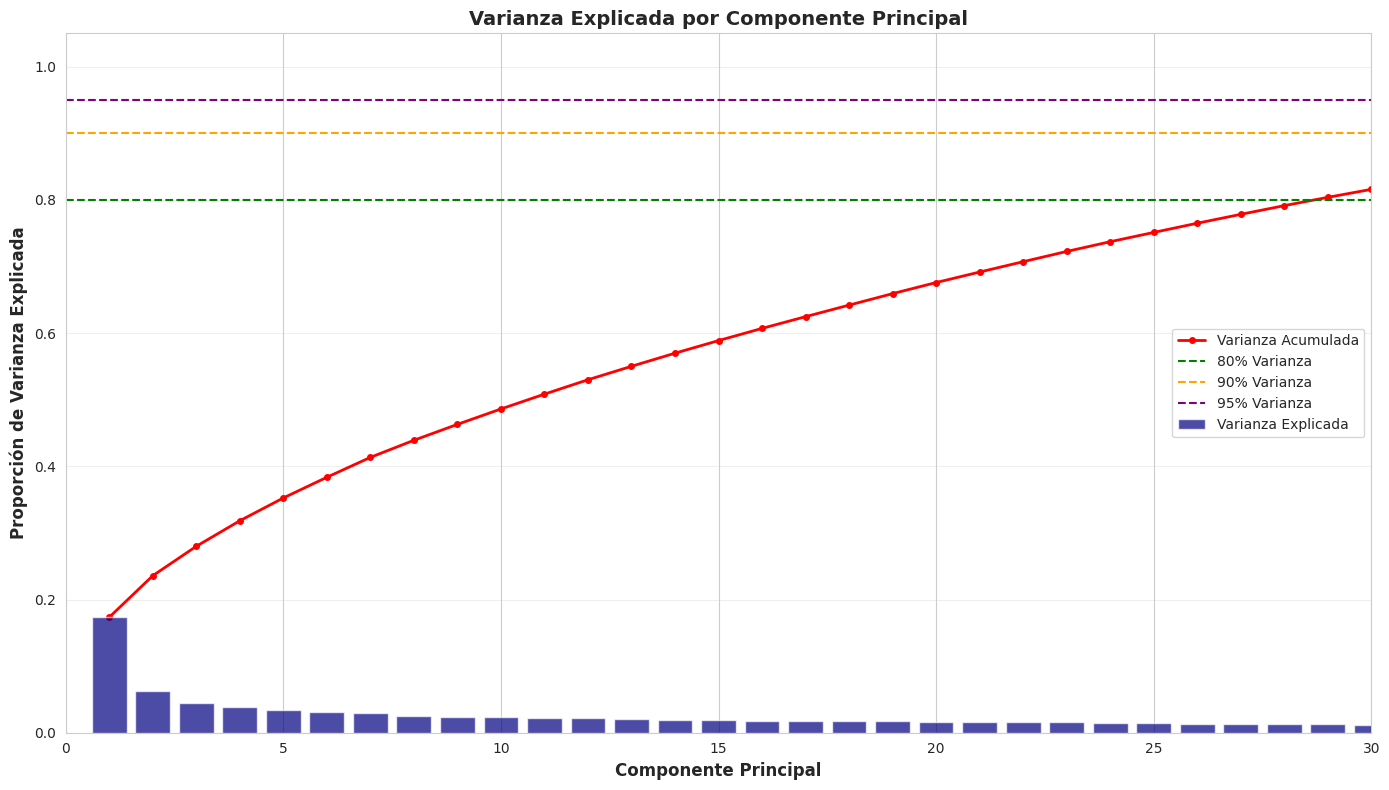


Gráfica guardada como: varianza_explicada_pca.png


In [ ]:
x_range = np.arange(1, len(explained_variance) + 1)

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(x=x_range, height=explained_variance, color='navy',
       label='Varianza Explicada', alpha=0.7, zorder=20)

ax.plot(x_range, cumulative_variance, color='red', marker='o',
        linestyle='-', linewidth=2, markersize=4,
        label='Varianza Acumulada')

ax.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5,
           label='80% Varianza')
ax.axhline(y=0.90, color='orange', linestyle='--', linewidth=1.5,
           label='90% Varianza')
ax.axhline(y=0.95, color='purple', linestyle='--', linewidth=1.5,
           label='95% Varianza')

ax.set_xlabel('Componente Principal', fontsize=12, fontweight='bold')
ax.set_ylabel('Proporción de Varianza Explicada', fontsize=12, fontweight='bold')
ax.set_title('Varianza Explicada por Componente Principal',
             fontsize=14, fontweight='bold')

ax.set_xlim(0, min(30, len(explained_variance) + 1))
ax.set_ylim(0, 1.05)

ax.legend(loc='center right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('varianza_explicada_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfica guardada como: varianza_explicada_pca.png")


#Gráfica de Varianza Acumulada con Detalles

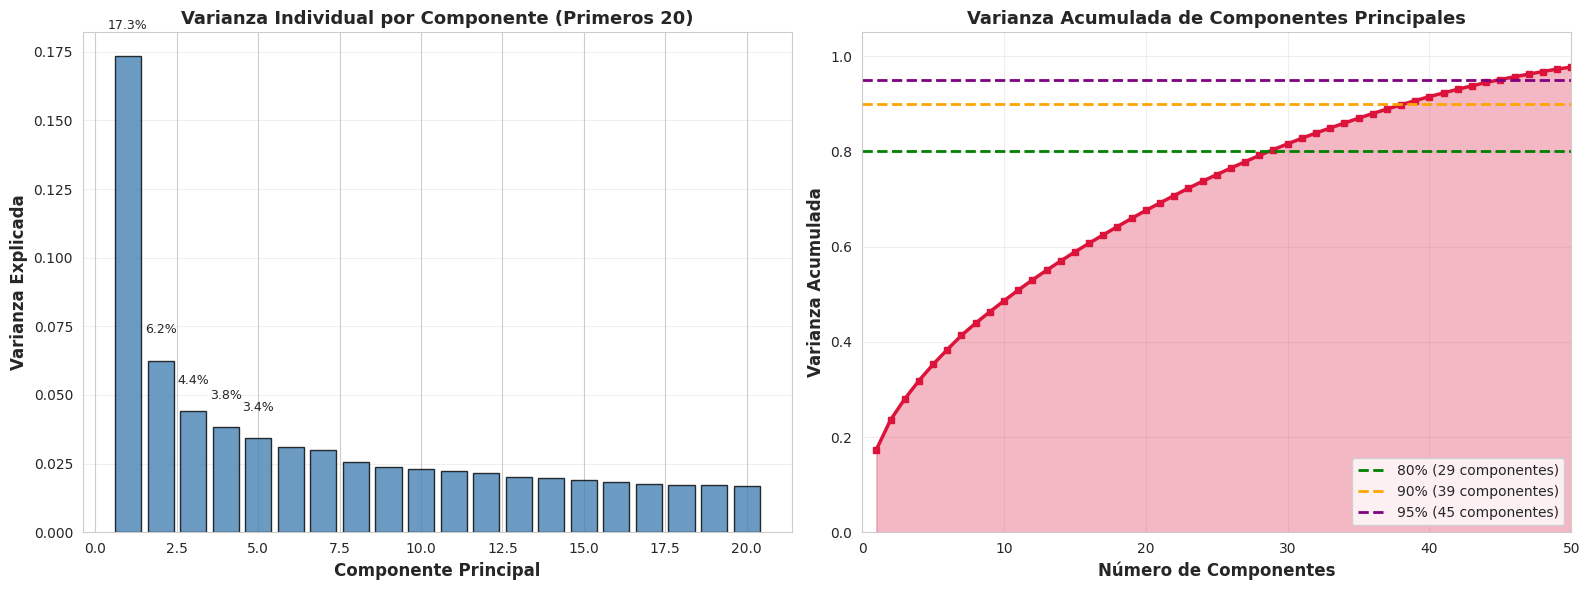

Gráfica guardada como: varianza_acumulada_detallada.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(x=x_range[:20], height=explained_variance[:20],
            color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Componente Principal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontsize=12, fontweight='bold')
axes[0].set_title('Varianza Individual por Componente (Primeros 20)',
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

for i in range(min(5, len(explained_variance))):
    axes[0].text(i+1, explained_variance[i] + 0.01,
                 f"{explained_variance[i]*100:.1f}%",
                 ha='center', fontsize=9)

axes[1].plot(x_range, cumulative_variance, color='crimson',
             marker='s', linewidth=2.5, markersize=5)
axes[1].fill_between(x_range, cumulative_variance, alpha=0.3, color='crimson')
axes[1].axhline(y=0.80, color='green', linestyle='--', linewidth=2,
                label=f'80% ({n_components_80} componentes)')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=2,
                label=f'90% ({n_components_90} componentes)')
axes[1].axhline(y=0.95, color='purple', linestyle='--', linewidth=2,
                label=f'95% ({n_components_95} componentes)')

axes[1].set_xlabel('Número de Componentes', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada', fontsize=12, fontweight='bold')
axes[1].set_title('Varianza Acumulada de Componentes Principales',
                  fontsize=13, fontweight='bold')
axes[1].set_xlim(0, min(50, len(explained_variance)))
axes[1].set_ylim(0, 1.05)
axes[1].legend(loc='lower right', fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('varianza_acumulada_detallada.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Gráfica guardada como: varianza_acumulada_detallada.png")


#Selección del Número Óptimo de Componentes

In [ ]:
umbral_varianza = 0.90

n_componentes_optimo = np.argmax(cumulative_variance >= umbral_varianza) + 1

print(f"SELECCIÓN DE COMPONENTES PARA PCA")
print("="*60)
print(f"Umbral de varianza seleccionado: {umbral_varianza*100}%")
print(f"Número óptimo de componentes: {n_componentes_optimo}")
print(f"Varianza explicada con {n_componentes_optimo} componentes: {cumulative_variance[n_componentes_optimo-1]*100:.2f}%")
print(f"\nReducción de dimensionalidad:")
print(f"Dimensiones originales: {X_train_scaled.shape[1]}")
print(f"Dimensiones reducidas: {n_componentes_optimo}")
print(f"Reducción: {((X_train_scaled.shape[1] - n_componentes_optimo) / X_train_scaled.shape[1])*100:.2f}%")


SELECCIÓN DE COMPONENTES PARA PCA
Umbral de varianza seleccionado: 90.0%
Número óptimo de componentes: 39
Varianza explicada con 39 componentes: 90.66%

Reducción de dimensionalidad:
Dimensiones originales: 67
Dimensiones reducidas: 39
Reducción: 41.79%


#Aplicación de PCA con Componentes Óptimos

In [ ]:
pca_optimal = PCA(n_components=n_componentes_optimo)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_test_pca = pca_optimal.transform(X_test_scaled)

print(f"TRANSFORMACIÓN PCA APLICADA")
print("="*60)
print(f"Dimensiones de entrenamiento original: {X_train_scaled.shape}")
print(f"Dimensiones de entrenamiento con PCA: {X_train_pca.shape}")
print(f"\nDimensiones de prueba original: {X_test_scaled.shape}")
print(f"Dimensiones de prueba con PCA: {X_test_pca.shape}")

import joblib
joblib.dump(pca_optimal, 'pca_model.pkl')
print(f"\nModelo PCA guardado como: pca_model.pkl")


TRANSFORMACIÓN PCA APLICADA
Dimensiones de entrenamiento original: (1289, 67)
Dimensiones de entrenamiento con PCA: (1289, 39)

Dimensiones de prueba original: (323, 67)
Dimensiones de prueba con PCA: (323, 39)

Modelo PCA guardado como: pca_model.pkl


#Biplot - Preparación de Datos

In [ ]:
print("PREPARACIÓN DE DATOS PARA BIPLOT")
print("="*60)

pca_biplot = PCA(n_components=2)
scores_biplot = pca_biplot.fit_transform(X_train_scaled)

dfScores = pd.DataFrame(scores_biplot, columns=['PC1', 'PC2'])

loadings = pca_biplot.components_.T
dfLoadings = pd.DataFrame(
    loadings,
    columns=['PC1', 'PC2'],
    index=X.columns
)

print(f"Varianza explicada por PC1: {pca_biplot.explained_variance_ratio_[0]*100:.2f}%")
print(f"Varianza explicada por PC2: {pca_biplot.explained_variance_ratio_[1]*100:.2f}%")
print(f"Varianza total explicada (PC1 + PC2): {sum(pca_biplot.explained_variance_ratio_)*100:.2f}%")

print(f"\nDimensiones de Scores: {dfScores.shape}")
print(f"Dimensiones de Loadings: {dfLoadings.shape}")


PREPARACIÓN DE DATOS PARA BIPLOT
Varianza explicada por PC1: 17.34%
Varianza explicada por PC2: 6.24%
Varianza total explicada (PC1 + PC2): 23.58%

Dimensiones de Scores: (1289, 2)
Dimensiones de Loadings: (67, 2)


#Identificación de Variables Más Significativas

In [ ]:
print("VARIABLES MÁS SIGNIFICATIVAS EN PC1 Y PC2")
print("="*60)

dfLoadings['Magnitude'] = np.sqrt(dfLoadings['PC1']**2 + dfLoadings['PC2']**2)
dfLoadings_sorted = dfLoadings.sort_values('Magnitude', ascending=False)

top_n = 10
print(f"\nTop {top_n} variables más significativas:")
print(dfLoadings_sorted.head(top_n))

top_variables = dfLoadings_sorted.head(top_n).index.tolist()

print(f"\nVariables seleccionadas para el Biplot:")
for i, var in enumerate(top_variables, 1):
    pc1_load = dfLoadings.loc[var, 'PC1']
    pc2_load = dfLoadings.loc[var, 'PC2']
    magnitude = dfLoadings.loc[var, 'Magnitude']
    print(f"{i}. {var}: PC1={pc1_load:.3f}, PC2={pc2_load:.3f}, Mag={magnitude:.3f}")


VARIABLES MÁS SIGNIFICATIVAS EN PC1 Y PC2

Top 10 variables más significativas:
                    PC1       PC2  Magnitude
Bldg Type      0.000605  0.440934   0.440935
MS SubClass   -0.014329  0.393257   0.393518
Lot Area       0.103674 -0.375624   0.389668
Lot Frontage   0.112663 -0.363779   0.380825
Year Built     0.266750  0.154450   0.308238
Garage Yr Blt  0.259914  0.133266   0.292088
TotRms AbvGrd  0.163422 -0.233651   0.285131
Bedroom AbvGr  0.048695 -0.261365   0.265863
Overall Qual   0.262922  0.007517   0.263030
Garage Cars    0.243748 -0.062485   0.251630

Variables seleccionadas para el Biplot:
1. Bldg Type: PC1=0.001, PC2=0.441, Mag=0.441
2. MS SubClass: PC1=-0.014, PC2=0.393, Mag=0.394
3. Lot Area: PC1=0.104, PC2=-0.376, Mag=0.390
4. Lot Frontage: PC1=0.113, PC2=-0.364, Mag=0.381
5. Year Built: PC1=0.267, PC2=0.154, Mag=0.308
6. Garage Yr Blt: PC1=0.260, PC2=0.133, Mag=0.292
7. TotRms AbvGrd: PC1=0.163, PC2=-0.234, Mag=0.285
8. Bedroom AbvGr: PC1=0.049, PC2=-0.261, Mag=

#Biplot Completo con Variables Significativas

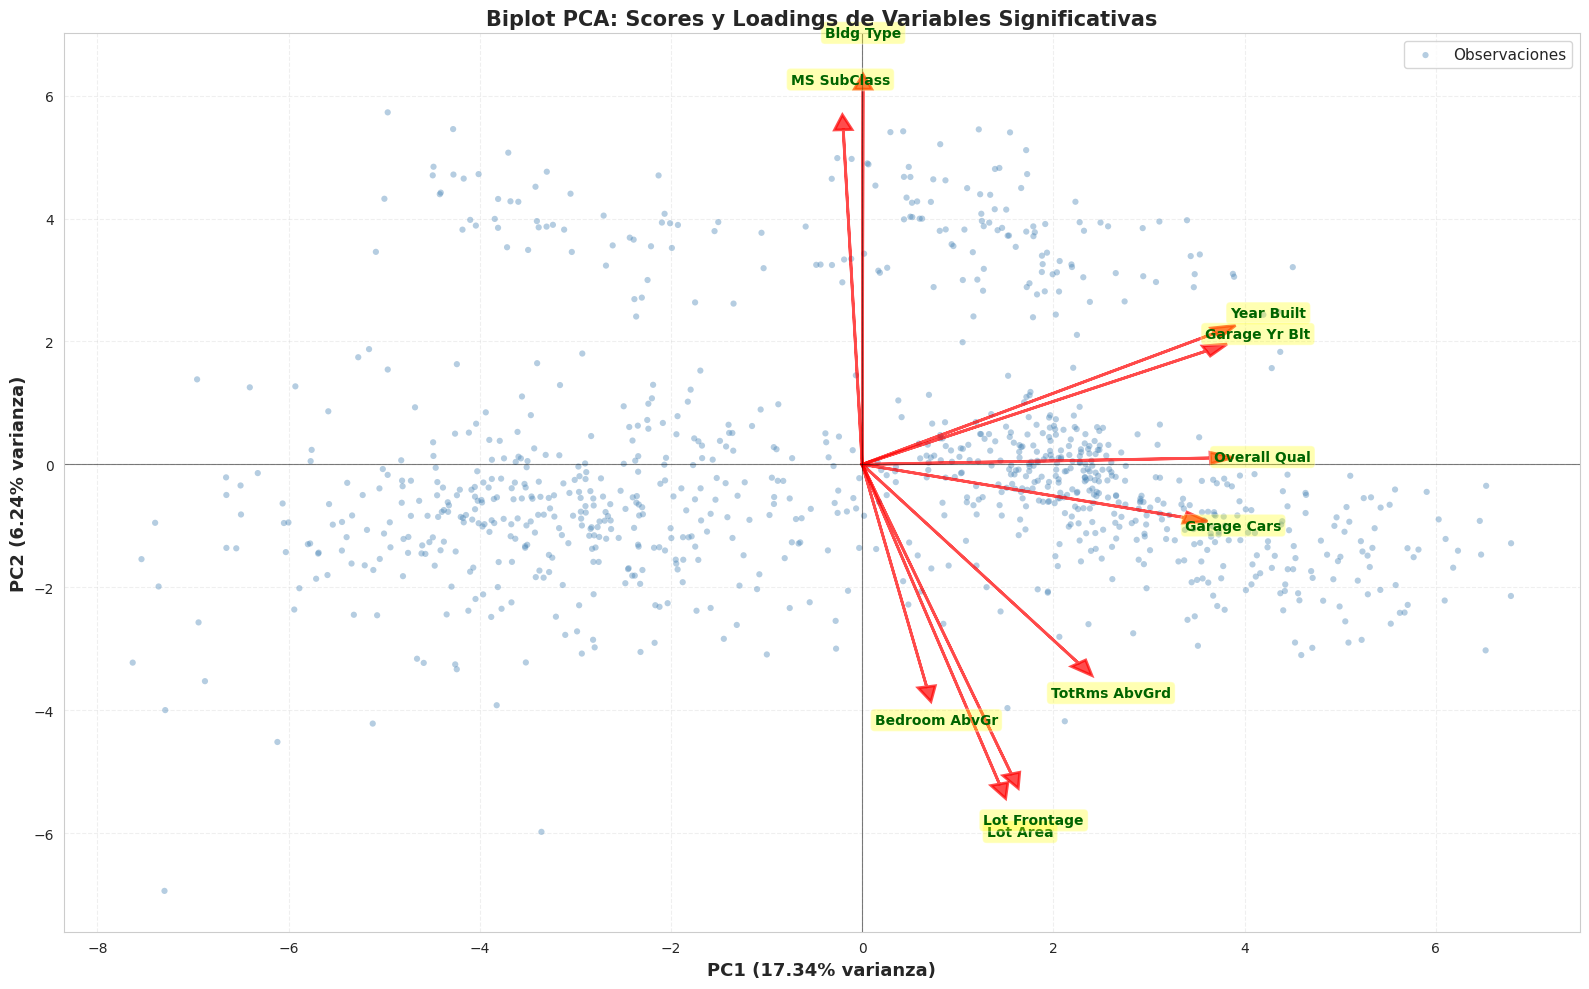

Biplot guardado como: biplot_pca_completo.png


In [ ]:
fig, ax = plt.subplots(figsize=(16, 10))

sample_size = min(1000, len(dfScores))
sample_indices = np.random.choice(len(dfScores), sample_size, replace=False)
dfScores_sample = dfScores.iloc[sample_indices]

ax.scatter(dfScores_sample['PC1'], dfScores_sample['PC2'],
           alpha=0.4, s=20, color='steelblue', edgecolors='none',
           label='Observaciones')

ax.set_xlabel(f'PC1 ({pca_biplot.explained_variance_ratio_[0]*100:.2f}% varianza)',
              fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_biplot.explained_variance_ratio_[1]*100:.2f}% varianza)',
              fontsize=13, fontweight='bold')
ax.set_title('Biplot PCA: Scores y Loadings de Variables Significativas',
             fontsize=15, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

scale_factor = 0.8 * max(
    abs(dfScores_sample['PC1'].max()),
    abs(dfScores_sample['PC1'].min()),
    abs(dfScores_sample['PC2'].max()),
    abs(dfScores_sample['PC2'].min())
)

for var in top_variables:
    pc1_load = dfLoadings.loc[var, 'PC1']
    pc2_load = dfLoadings.loc[var, 'PC2']

    arrow_scale = scale_factor / max(abs(dfLoadings['PC1'].max()),
                                     abs(dfLoadings['PC2'].max()))

    tipx = pc1_load * arrow_scale
    tipy = pc2_load * arrow_scale

    ax.arrow(0, 0, tipx, tipy,
             head_width=scale_factor*0.03,
             head_length=scale_factor*0.04,
             fc='red', ec='red', alpha=0.7, linewidth=2)

    ax.text(tipx*1.15, tipy*1.15, var,
            fontsize=10, fontweight='bold', color='darkgreen',
            ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig('biplot_pca_completo.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Biplot guardado como: biplot_pca_completo.png")


#Biplot Alternativo con Todas las Variables

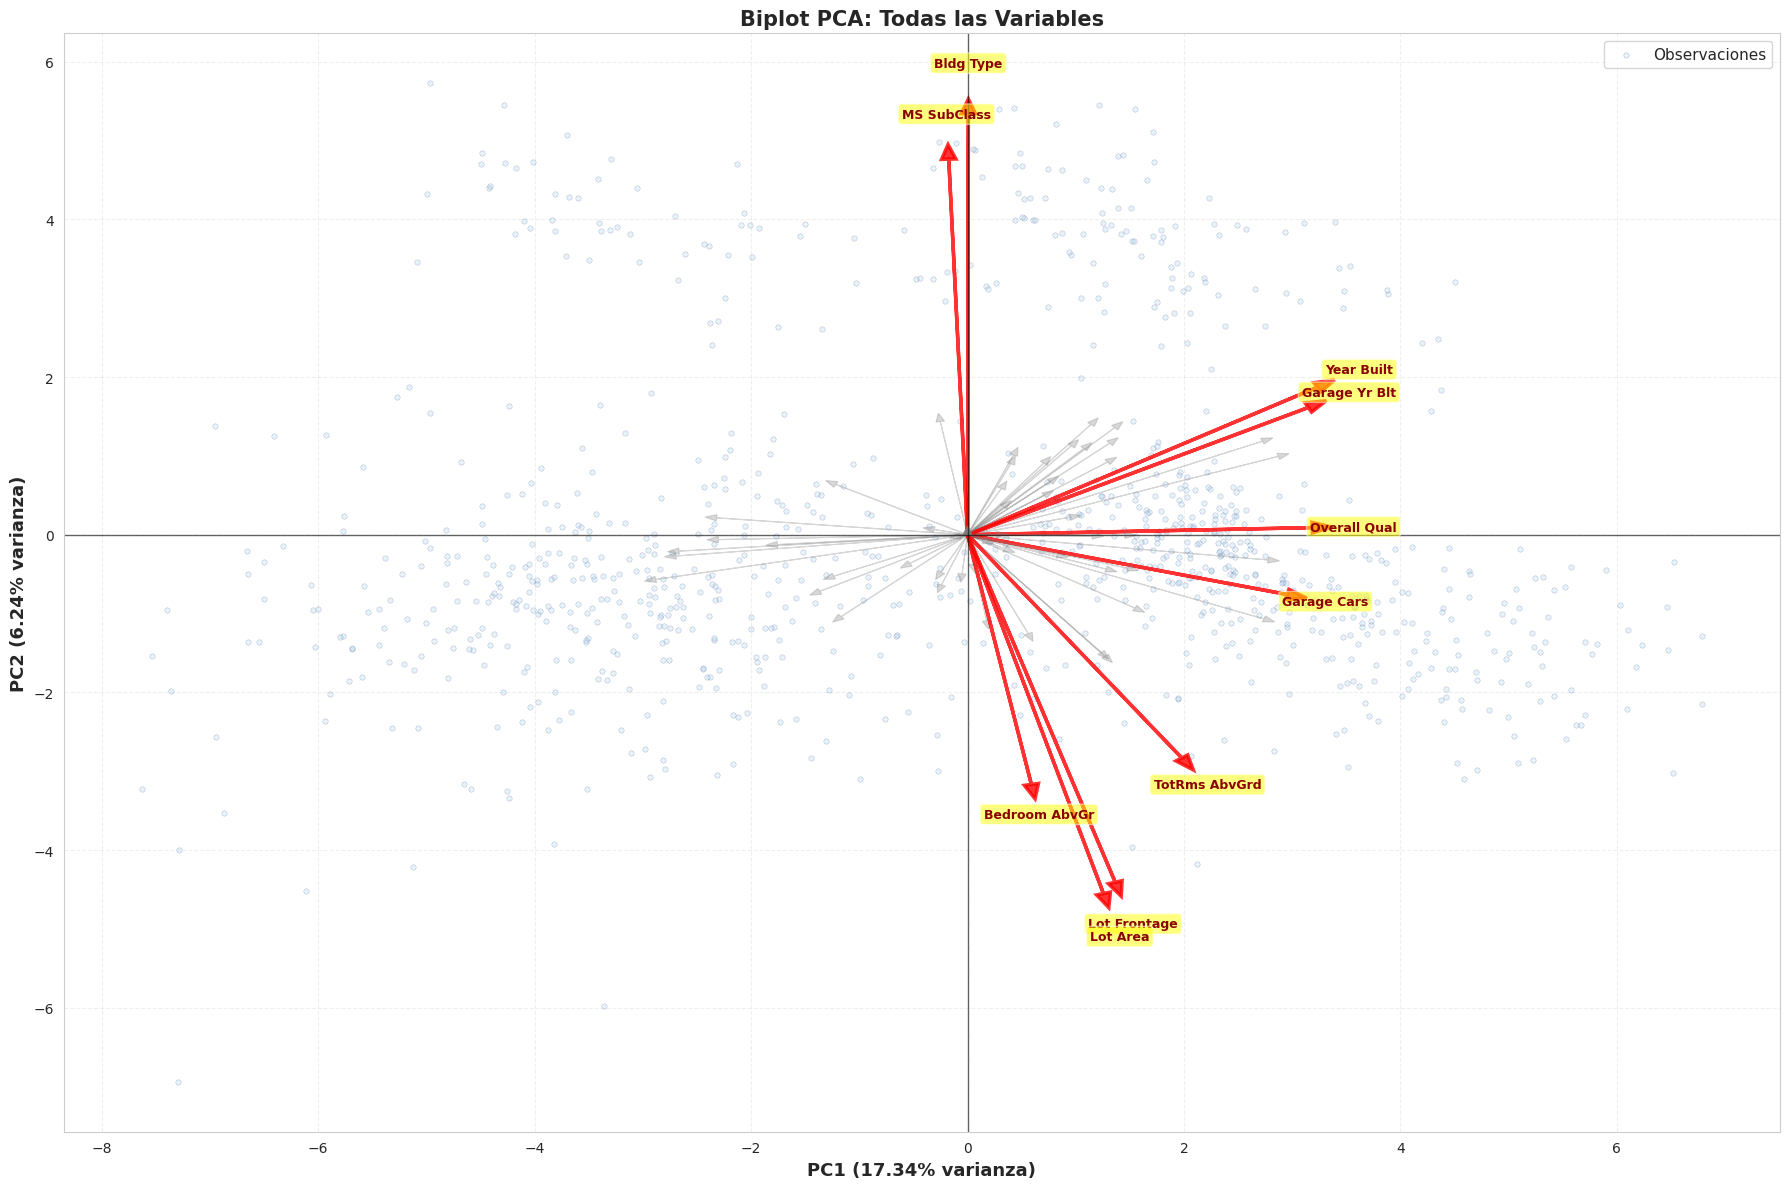

Biplot con todas las variables guardado como: biplot_pca_todas_variables.png


In [ ]:
fig, ax = plt.subplots(figsize=(18, 12))

ax.scatter(dfScores_sample['PC1'], dfScores_sample['PC2'],
           alpha=0.3, s=15, color='lightblue', edgecolors='navy',
           linewidths=0.3, label='Observaciones')

ax.set_xlabel(f'PC1 ({pca_biplot.explained_variance_ratio_[0]*100:.2f}% varianza)',
              fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_biplot.explained_variance_ratio_[1]*100:.2f}% varianza)',
              fontsize=13, fontweight='bold')
ax.set_title('Biplot PCA: Todas las Variables',
             fontsize=15, fontweight='bold')

ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.6)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.6)

scale_factor = 0.7 * max(
    abs(dfScores_sample['PC1'].max()),
    abs(dfScores_sample['PC1'].min()),
    abs(dfScores_sample['PC2'].max()),
    abs(dfScores_sample['PC2'].min())
)

arrow_scale = scale_factor / max(abs(dfLoadings['PC1'].max()),
                                 abs(dfLoadings['PC2'].max()))

for i, var in enumerate(dfLoadings.index):
    pc1_load = dfLoadings.loc[var, 'PC1']
    pc2_load = dfLoadings.loc[var, 'PC2']

    tipx = pc1_load * arrow_scale
    tipy = pc2_load * arrow_scale

    if var in top_variables:
        ax.arrow(0, 0, tipx, tipy,
                 head_width=scale_factor*0.025,
                 head_length=scale_factor*0.035,
                 fc='red', ec='red', alpha=0.8, linewidth=2.5)

        ax.text(tipx*1.12, tipy*1.12, var,
                fontsize=9, fontweight='bold', color='darkred',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    else:
        ax.arrow(0, 0, tipx, tipy,
                 head_width=scale_factor*0.015,
                 head_length=scale_factor*0.02,
                 fc='gray', ec='gray', alpha=0.3, linewidth=0.8)

ax.grid(alpha=0.3, linestyle='--')
ax.legend(loc='upper right', fontsize=11)

plt.tight_layout()
plt.savefig('biplot_pca_todas_variables.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Biplot con todas las variables guardado como: biplot_pca_todas_variables.png")


#Análisis de Contribución de Variables a los Componentes

In [ ]:
print("CONTRIBUCIÓN DE VARIABLES A LOS COMPONENTES PRINCIPALES")
print("="*60)

contributions_pc1 = pd.DataFrame({
    'Variable': dfLoadings.index,
    'Loading_PC1': dfLoadings['PC1'],
    'Contribution_PC1': (dfLoadings['PC1']**2) / (dfLoadings['PC1']**2).sum() * 100
})

contributions_pc1 = contributions_pc1.sort_values('Contribution_PC1', ascending=False)

print("\nTop 15 variables con mayor contribución a PC1:")
print(contributions_pc1.head(15).to_string(index=False))

contributions_pc2 = pd.DataFrame({
    'Variable': dfLoadings.index,
    'Loading_PC2': dfLoadings['PC2'],
    'Contribution_PC2': (dfLoadings['PC2']**2) / (dfLoadings['PC2']**2).sum() * 100
})

contributions_pc2 = contributions_pc2.sort_values('Contribution_PC2', ascending=False)

print("\n\nTop 15 variables con mayor contribución a PC2:")
print(contributions_pc2.head(15).to_string(index=False))

contributions_pc1.to_csv('contribuciones_pc1.csv', index=False)
contributions_pc2.to_csv('contribuciones_pc2.csv', index=False)

print("\n\nArchivos guardados:")
print("- contribuciones_pc1.csv")
print("- contribuciones_pc2.csv")


CONTRIBUCIÓN DE VARIABLES A LOS COMPONENTES PRINCIPALES

Top 15 variables con mayor contribución a PC1:
      Variable  Loading_PC1  Contribution_PC1
    Year Built     0.266750          7.115563
  Overall Qual     0.262922          6.912815
 Garage Yr Blt     0.259914          6.755549
   Garage Cars     0.243748          5.941316
     Bsmt Qual    -0.237815          5.655609
Year Remod/Add     0.236991          5.616490
     Full Bath     0.229236          5.254915
   Garage Area     0.226052          5.109930
    Foundation     0.224896          5.057842
    Exter Qual    -0.222444          4.948127
 Garage Finish    -0.220107          4.844702
  Kitchen Qual    -0.191380          3.662623
    Heating QC    -0.190049          3.611860
 TotRms AbvGrd     0.163422          2.670687
   Garage Type    -0.144953          2.101135


Top 15 variables con mayor contribución a PC2:
     Variable  Loading_PC2  Contribution_PC2
    Bldg Type     0.440934         19.442294
  MS SubClass     0.3

#Gráfica de Contribuciones de Variables

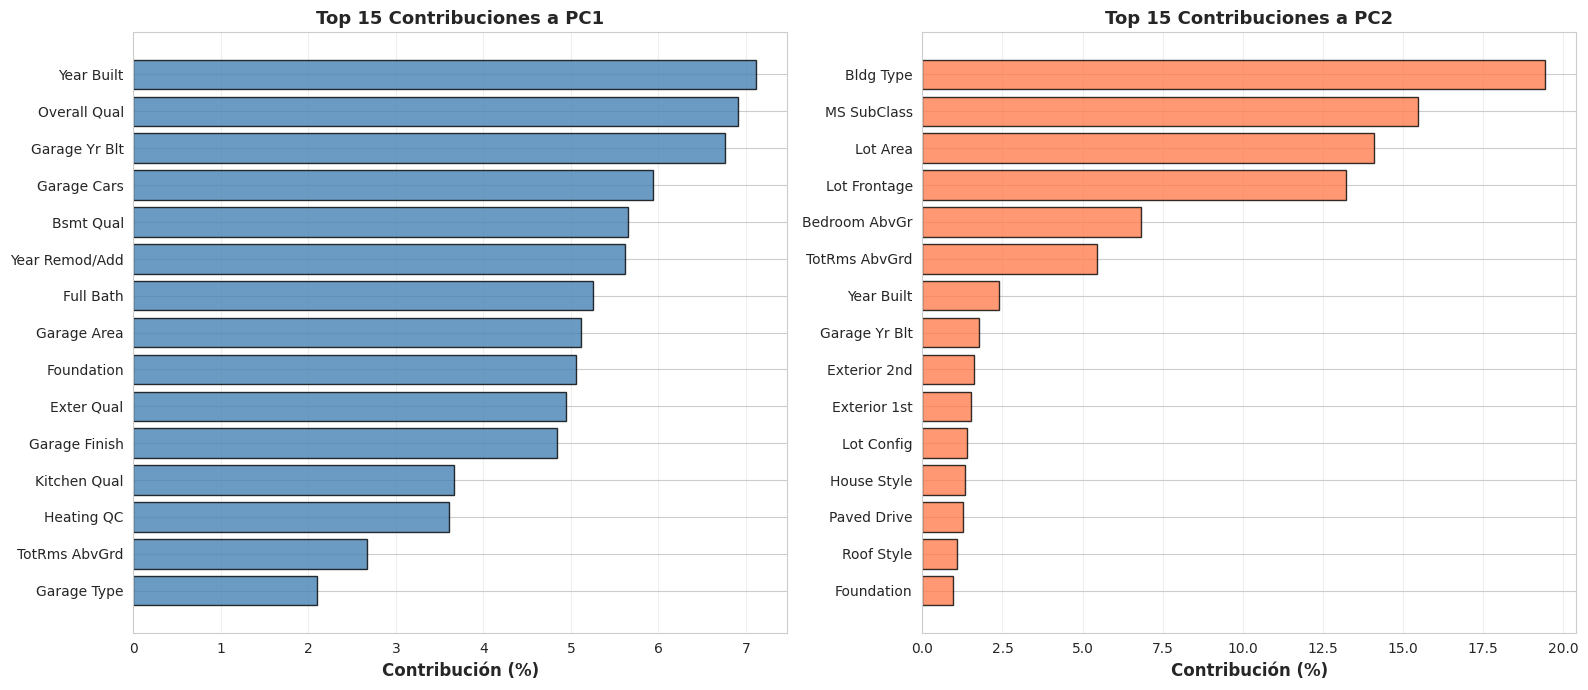

Gráfica de contribuciones guardada como: contribuciones_variables_pc.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

top_contributions_pc1 = contributions_pc1.head(15)
axes[0].barh(top_contributions_pc1['Variable'],
             top_contributions_pc1['Contribution_PC1'],
             color='steelblue', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Contribución (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Top 15 Contribuciones a PC1', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

top_contributions_pc2 = contributions_pc2.head(15)
axes[1].barh(top_contributions_pc2['Variable'],
             top_contributions_pc2['Contribution_PC2'],
             color='coral', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Contribución (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Top 15 Contribuciones a PC2', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('contribuciones_variables_pc.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Gráfica de contribuciones guardada como: contribuciones_variables_pc.png")


#Reentramiento de Modelos con PCA

#Modelo 1 con PCA - Regresión Lineal

MODELO 1 CON PCA: REGRESIÓN LINEAL
R² Entrenamiento: 0.8805
R² Prueba: 0.8557
RMSE Entrenamiento: 25282.48
RMSE Prueba: 28138.88
MSE Prueba: 791796770.78
Validación Cruzada R² (promedio): 0.8431 (+/- 0.0512)


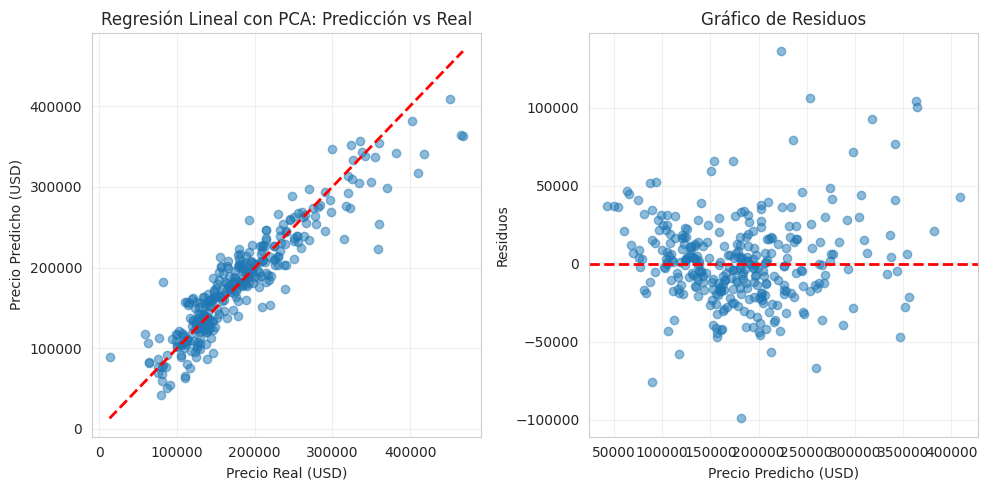

In [ ]:
print("MODELO 1 CON PCA: REGRESIÓN LINEAL")
print("="*60)

lr_pca = LinearRegression()
lr_pca.fit(X_train_pca, y_train)

y_pred_lr_pca_train = lr_pca.predict(X_train_pca)
y_pred_lr_pca_test = lr_pca.predict(X_test_pca)

r2_train_lr_pca = r2_score(y_train, y_pred_lr_pca_train)
r2_test_lr_pca = r2_score(y_test, y_pred_lr_pca_test)
rmse_train_lr_pca = np.sqrt(mean_squared_error(y_train, y_pred_lr_pca_train))
rmse_test_lr_pca = np.sqrt(mean_squared_error(y_test, y_pred_lr_pca_test))
mse_test_lr_pca = mean_squared_error(y_test, y_pred_lr_pca_test)

cv_scores_lr_pca = cross_val_score(lr_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_lr_pca:.4f}")
print(f"R² Prueba: {r2_test_lr_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_lr_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_lr_pca:.2f}")
print(f"MSE Prueba: {mse_test_lr_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_lr_pca.mean():.4f} (+/- {cv_scores_lr_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lr_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Lineal con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_lr_pca_test
plt.scatter(y_pred_lr_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo1_pca_regresion_lineal.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 2 con PCA - Regresión Ridge

MODELO 2 CON PCA: REGRESIÓN RIDGE
Mejor alpha: 100.0
R² Entrenamiento: 0.8801
R² Prueba: 0.8535
RMSE Entrenamiento: 25318.37
RMSE Prueba: 28347.59
MSE Prueba: 803585639.74
Validación Cruzada R² (promedio): 0.8701 (+/- 0.0173)


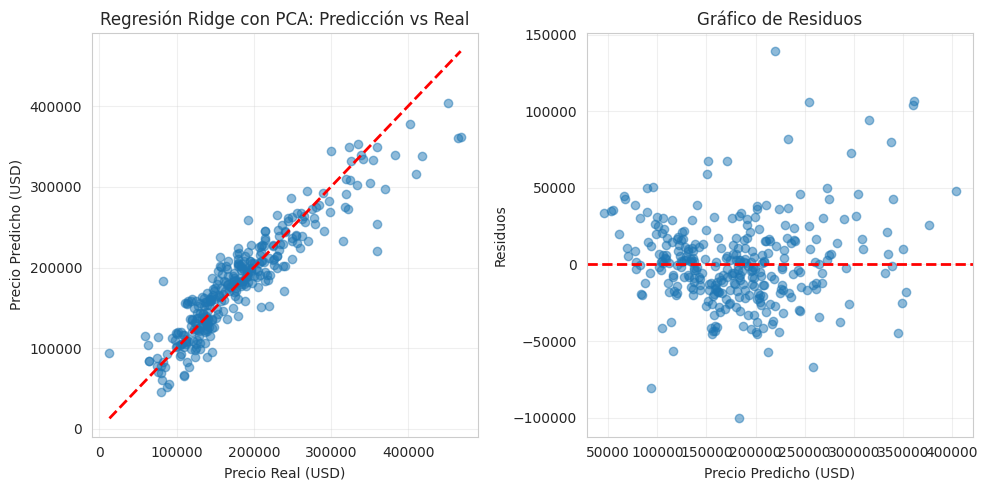

In [ ]:
print("MODELO 2 CON PCA: REGRESIÓN RIDGE")
print("="*60)

param_grid_ridge_pca = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_pca = Ridge()
grid_ridge_pca = GridSearchCV(ridge_pca, param_grid_ridge_pca, cv=5, scoring='r2', n_jobs=-1)
grid_ridge_pca.fit(X_train_pca, y_train)

best_ridge_pca = grid_ridge_pca.best_estimator_
print(f"Mejor alpha: {grid_ridge_pca.best_params_['alpha']}")

y_pred_ridge_pca_train = best_ridge_pca.predict(X_train_pca)
y_pred_ridge_pca_test = best_ridge_pca.predict(X_test_pca)

r2_train_ridge_pca = r2_score(y_train, y_pred_ridge_pca_train)
r2_test_ridge_pca = r2_score(y_test, y_pred_ridge_pca_test)
rmse_train_ridge_pca = np.sqrt(mean_squared_error(y_train, y_pred_ridge_pca_train))
rmse_test_ridge_pca = np.sqrt(mean_squared_error(y_test, y_pred_ridge_pca_test))
mse_test_ridge_pca = mean_squared_error(y_test, y_pred_ridge_pca_test)

cv_scores_ridge_pca = cross_val_score(best_ridge_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_ridge_pca:.4f}")
print(f"R² Prueba: {r2_test_ridge_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_ridge_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_ridge_pca:.2f}")
print(f"MSE Prueba: {mse_test_ridge_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_ridge_pca.mean():.4f} (+/- {cv_scores_ridge_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ridge_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Ridge con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_ridge_pca_test
plt.scatter(y_pred_ridge_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo2_pca_regresion_ridge.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 3 con PCA - Regresión Lasso

MODELO 3 CON PCA: REGRESIÓN LASSO
Mejor alpha: 100.0
R² Entrenamiento: 0.8804
R² Prueba: 0.8546
RMSE Entrenamiento: 25290.42
RMSE Prueba: 28244.05
MSE Prueba: 797726517.81
Validación Cruzada R² (promedio): 0.8691 (+/- 0.0174)


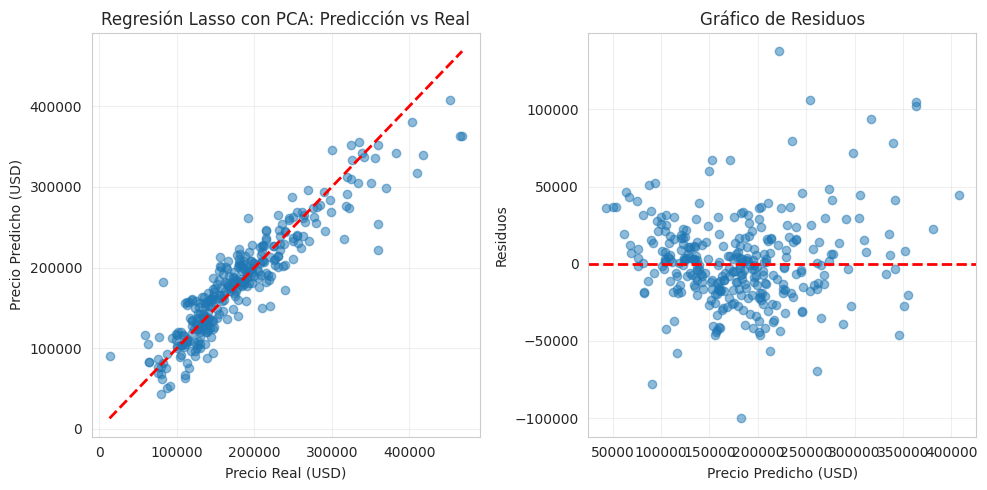

In [ ]:
print("MODELO 3 CON PCA: REGRESIÓN LASSO")
print("="*60)

param_grid_lasso_pca = {'alpha': [0.1, 1.0, 10.0, 100.0]}

lasso_pca = Lasso()
grid_lasso_pca = GridSearchCV(lasso_pca, param_grid_lasso_pca, cv=5, scoring='r2', n_jobs=-1)
grid_lasso_pca.fit(X_train_pca, y_train)

best_lasso_pca = grid_lasso_pca.best_estimator_
print(f"Mejor alpha: {grid_lasso_pca.best_params_['alpha']}")

y_pred_lasso_pca_train = best_lasso_pca.predict(X_train_pca)
y_pred_lasso_pca_test = best_lasso_pca.predict(X_test_pca)

r2_train_lasso_pca = r2_score(y_train, y_pred_lasso_pca_train)
r2_test_lasso_pca = r2_score(y_test, y_pred_lasso_pca_test)
rmse_train_lasso_pca = np.sqrt(mean_squared_error(y_train, y_pred_lasso_pca_train))
rmse_test_lasso_pca = np.sqrt(mean_squared_error(y_test, y_pred_lasso_pca_test))
mse_test_lasso_pca = mean_squared_error(y_test, y_pred_lasso_pca_test)

cv_scores_lasso_pca = cross_val_score(best_lasso_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_lasso_pca:.4f}")
print(f"R² Prueba: {r2_test_lasso_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_lasso_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_lasso_pca:.2f}")
print(f"MSE Prueba: {mse_test_lasso_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_lasso_pca.mean():.4f} (+/- {cv_scores_lasso_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_lasso_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Regresión Lasso con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_lasso_pca_test
plt.scatter(y_pred_lasso_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo3_pca_regresion_lasso.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 4 con PCA - Árbol de Decisión

MODELO 4 CON PCA: ÁRBOL DE DECISIÓN
Mejores parámetros: {'max_depth': 5, 'min_samples_split': 10}
R² Entrenamiento: 0.8860
R² Prueba: 0.8149
RMSE Entrenamiento: 24695.40
RMSE Prueba: 31865.66
MSE Prueba: 1015420317.96
Validación Cruzada R² (promedio): 0.7975 (+/- 0.0243)


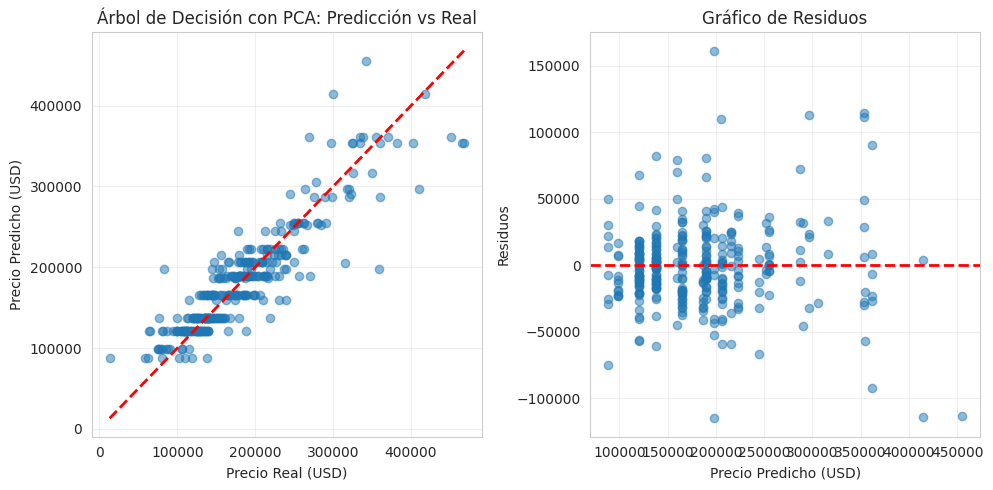

In [ ]:
print("MODELO 4 CON PCA: ÁRBOL DE DECISIÓN")
print("="*60)

param_grid_dt_pca = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

dt_pca = DecisionTreeRegressor(random_state=42)
grid_dt_pca = GridSearchCV(dt_pca, param_grid_dt_pca, cv=5, scoring='r2', n_jobs=-1)
grid_dt_pca.fit(X_train_pca, y_train)

best_dt_pca = grid_dt_pca.best_estimator_
print(f"Mejores parámetros: {grid_dt_pca.best_params_}")

y_pred_dt_pca_train = best_dt_pca.predict(X_train_pca)
y_pred_dt_pca_test = best_dt_pca.predict(X_test_pca)

r2_train_dt_pca = r2_score(y_train, y_pred_dt_pca_train)
r2_test_dt_pca = r2_score(y_test, y_pred_dt_pca_test)
rmse_train_dt_pca = np.sqrt(mean_squared_error(y_train, y_pred_dt_pca_train))
rmse_test_dt_pca = np.sqrt(mean_squared_error(y_test, y_pred_dt_pca_test))
mse_test_dt_pca = mean_squared_error(y_test, y_pred_dt_pca_test)

cv_scores_dt_pca = cross_val_score(best_dt_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_dt_pca:.4f}")
print(f"R² Prueba: {r2_test_dt_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_dt_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_dt_pca:.2f}")
print(f"MSE Prueba: {mse_test_dt_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_dt_pca.mean():.4f} (+/- {cv_scores_dt_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_dt_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Árbol de Decisión con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_dt_pca_test
plt.scatter(y_pred_dt_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo4_pca_arbol_decision.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 5 con PCA - Random Forest

MODELO 5 CON PCA: RANDOM FOREST
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
R² Entrenamiento: 0.9781
R² Prueba: 0.8418
RMSE Entrenamiento: 10819.70
RMSE Prueba: 29465.28
MSE Prueba: 868202685.83
Validación Cruzada R² (promedio): 0.8655 (+/- 0.0176)


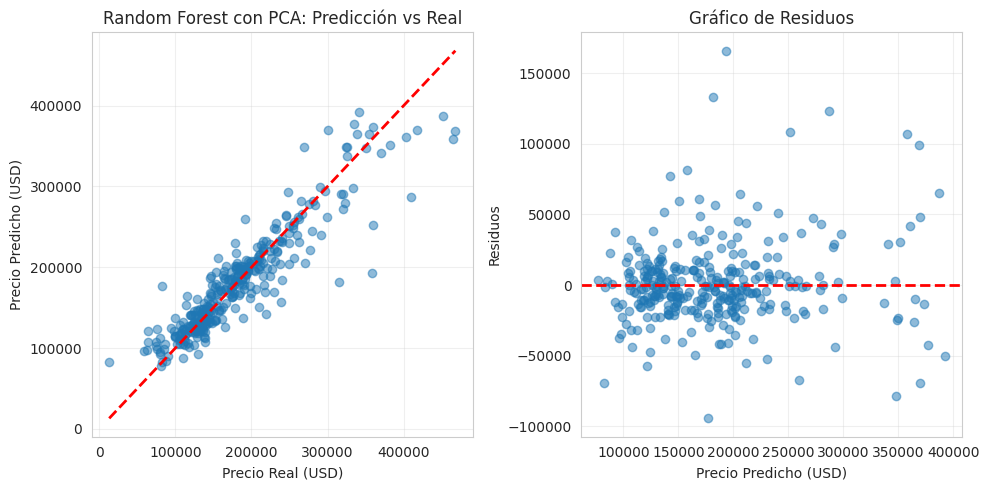

In [ ]:
print("MODELO 5 CON PCA: RANDOM FOREST")
print("="*60)

param_grid_rf_pca = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

rf_pca = RandomForestRegressor(random_state=42)
grid_rf_pca = GridSearchCV(rf_pca, param_grid_rf_pca, cv=5, scoring='r2', n_jobs=-1)
grid_rf_pca.fit(X_train_pca, y_train)

best_rf_pca = grid_rf_pca.best_estimator_
print(f"Mejores parámetros: {grid_rf_pca.best_params_}")

y_pred_rf_pca_train = best_rf_pca.predict(X_train_pca)
y_pred_rf_pca_test = best_rf_pca.predict(X_test_pca)

r2_train_rf_pca = r2_score(y_train, y_pred_rf_pca_train)
r2_test_rf_pca = r2_score(y_test, y_pred_rf_pca_test)
rmse_train_rf_pca = np.sqrt(mean_squared_error(y_train, y_pred_rf_pca_train))
rmse_test_rf_pca = np.sqrt(mean_squared_error(y_test, y_pred_rf_pca_test))
mse_test_rf_pca = mean_squared_error(y_test, y_pred_rf_pca_test)

cv_scores_rf_pca = cross_val_score(best_rf_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_rf_pca:.4f}")
print(f"R² Prueba: {r2_test_rf_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_rf_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_rf_pca:.2f}")
print(f"MSE Prueba: {mse_test_rf_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_rf_pca.mean():.4f} (+/- {cv_scores_rf_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_rf_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Random Forest con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_rf_pca_test
plt.scatter(y_pred_rf_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo5_pca_random_forest.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 6 con PCA - Gradient Boosting

MODELO 6 CON PCA: GRADIENT BOOSTING
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
R² Entrenamiento: 0.9772
R² Prueba: 0.8493
RMSE Entrenamiento: 11038.43
RMSE Prueba: 28754.81
MSE Prueba: 826838867.36
Validación Cruzada R² (promedio): 0.8698 (+/- 0.0096)


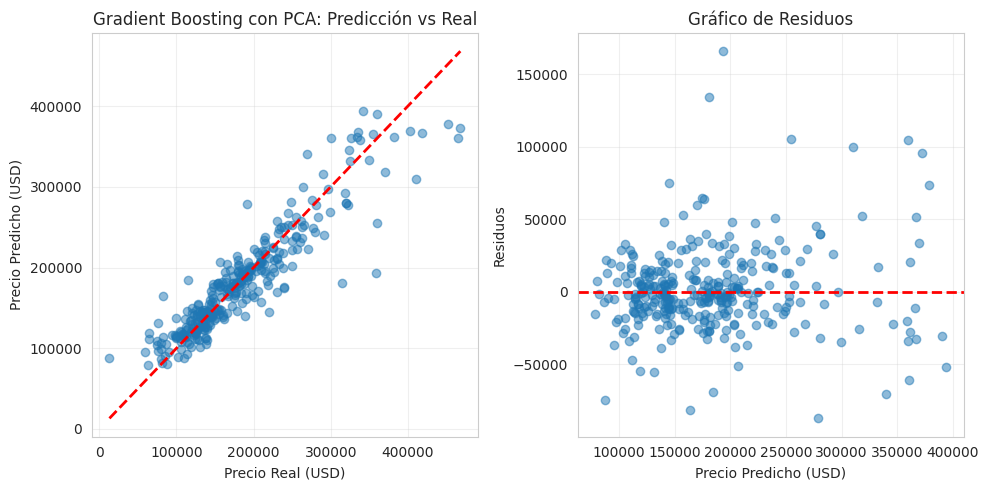

In [ ]:
print("MODELO 6 CON PCA: GRADIENT BOOSTING")
print("="*60)

param_grid_gb_pca = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_pca = GradientBoostingRegressor(random_state=42)
grid_gb_pca = GridSearchCV(gb_pca, param_grid_gb_pca, cv=5, scoring='r2', n_jobs=-1)
grid_gb_pca.fit(X_train_pca, y_train)

best_gb_pca = grid_gb_pca.best_estimator_
print(f"Mejores parámetros: {grid_gb_pca.best_params_}")

y_pred_gb_pca_train = best_gb_pca.predict(X_train_pca)
y_pred_gb_pca_test = best_gb_pca.predict(X_test_pca)

r2_train_gb_pca = r2_score(y_train, y_pred_gb_pca_train)
r2_test_gb_pca = r2_score(y_test, y_pred_gb_pca_test)
rmse_train_gb_pca = np.sqrt(mean_squared_error(y_train, y_pred_gb_pca_train))
rmse_test_gb_pca = np.sqrt(mean_squared_error(y_test, y_pred_gb_pca_test))
mse_test_gb_pca = mean_squared_error(y_test, y_pred_gb_pca_test)

cv_scores_gb_pca = cross_val_score(best_gb_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_gb_pca:.4f}")
print(f"R² Prueba: {r2_test_gb_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_gb_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_gb_pca:.2f}")
print(f"MSE Prueba: {mse_test_gb_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_gb_pca.mean():.4f} (+/- {cv_scores_gb_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gb_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Gradient Boosting con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_gb_pca_test
plt.scatter(y_pred_gb_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo6_pca_gradient_boosting.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 7 con PCA - AdaBoost Regressor

MODELO 7 CON PCA: ADABOOST REGRESSOR
Mejores parámetros: {'learning_rate': 1.0, 'n_estimators': 100}
R² Entrenamiento: 0.8771
R² Prueba: 0.8040
RMSE Entrenamiento: 25631.55
RMSE Prueba: 32795.93
MSE Prueba: 1075572928.81
Validación Cruzada R² (promedio): 0.8250 (+/- 0.0184)


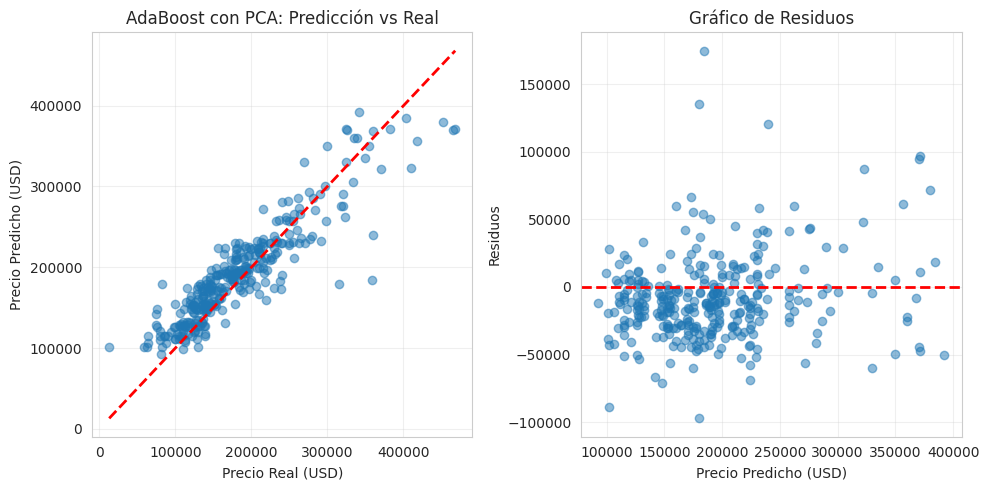

In [ ]:
print("MODELO 7 CON PCA: ADABOOST REGRESSOR")
print("="*60)

param_grid_ada_pca = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

ada_pca = AdaBoostRegressor(random_state=42)
grid_ada_pca = GridSearchCV(ada_pca, param_grid_ada_pca, cv=5, scoring='r2', n_jobs=-1)
grid_ada_pca.fit(X_train_pca, y_train)

best_ada_pca = grid_ada_pca.best_estimator_
print(f"Mejores parámetros: {grid_ada_pca.best_params_}")

y_pred_ada_pca_train = best_ada_pca.predict(X_train_pca)
y_pred_ada_pca_test = best_ada_pca.predict(X_test_pca)

r2_train_ada_pca = r2_score(y_train, y_pred_ada_pca_train)
r2_test_ada_pca = r2_score(y_test, y_pred_ada_pca_test)
rmse_train_ada_pca = np.sqrt(mean_squared_error(y_train, y_pred_ada_pca_train))
rmse_test_ada_pca = np.sqrt(mean_squared_error(y_test, y_pred_ada_pca_test))
mse_test_ada_pca = mean_squared_error(y_test, y_pred_ada_pca_test)

cv_scores_ada_pca = cross_val_score(best_ada_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_ada_pca:.4f}")
print(f"R² Prueba: {r2_test_ada_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_ada_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_ada_pca:.2f}")
print(f"MSE Prueba: {mse_test_ada_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_ada_pca.mean():.4f} (+/- {cv_scores_ada_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_ada_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('AdaBoost con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_ada_pca_test
plt.scatter(y_pred_ada_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo7_pca_adaboost.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 8 con PCA - Support Vector Machine (SVR)

MODELO 8 CON PCA: SUPPORT VECTOR MACHINE (SVR)
Mejores parámetros: {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'}
R² Entrenamiento: 0.8632
R² Prueba: 0.8293
RMSE Entrenamiento: 27049.13
RMSE Prueba: 30606.73
MSE Prueba: 936771854.48
Validación Cruzada R² (promedio): 0.8556 (+/- 0.0210)


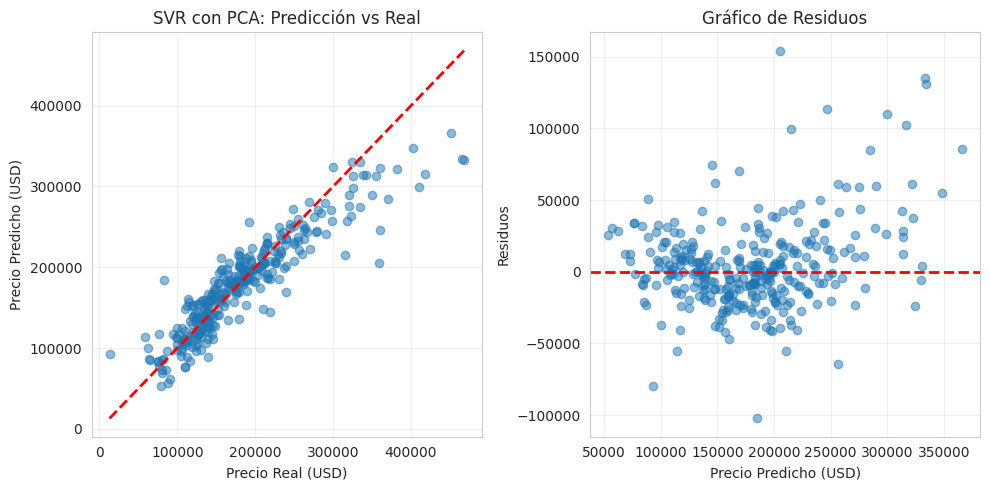

In [ ]:
print("MODELO 8 CON PCA: SUPPORT VECTOR MACHINE (SVR)")
print("="*60)

param_grid_svr_pca = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf', 'linear']
}

svr_pca = SVR()
grid_svr_pca = GridSearchCV(svr_pca, param_grid_svr_pca, cv=5, scoring='r2', n_jobs=-1)
grid_svr_pca.fit(X_train_pca, y_train)

best_svr_pca = grid_svr_pca.best_estimator_
print(f"Mejores parámetros: {grid_svr_pca.best_params_}")

y_pred_svr_pca_train = best_svr_pca.predict(X_train_pca)
y_pred_svr_pca_test = best_svr_pca.predict(X_test_pca)

r2_train_svr_pca = r2_score(y_train, y_pred_svr_pca_train)
r2_test_svr_pca = r2_score(y_test, y_pred_svr_pca_test)
rmse_train_svr_pca = np.sqrt(mean_squared_error(y_train, y_pred_svr_pca_train))
rmse_test_svr_pca = np.sqrt(mean_squared_error(y_test, y_pred_svr_pca_test))
mse_test_svr_pca = mean_squared_error(y_test, y_pred_svr_pca_test)

cv_scores_svr_pca = cross_val_score(best_svr_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_svr_pca:.4f}")
print(f"R² Prueba: {r2_test_svr_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_svr_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_svr_pca:.2f}")
print(f"MSE Prueba: {mse_test_svr_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_svr_pca.mean():.4f} (+/- {cv_scores_svr_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_svr_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('SVR con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_svr_pca_test
plt.scatter(y_pred_svr_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo8_pca_svr.png', dpi=300, bbox_inches='tight')
plt.show()


#Modelo 9 con PCA - MLP Regressor (Red Neuronal)

MODELO 9 CON PCA: MLP REGRESSOR (RED NEURONAL)
Mejores parámetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant'}
R² Entrenamiento: 0.9316
R² Prueba: 0.8603
RMSE Entrenamiento: 19118.27
RMSE Prueba: 27682.46
MSE Prueba: 766318768.28
Validación Cruzada R² (promedio): 0.8512 (+/- 0.0164)


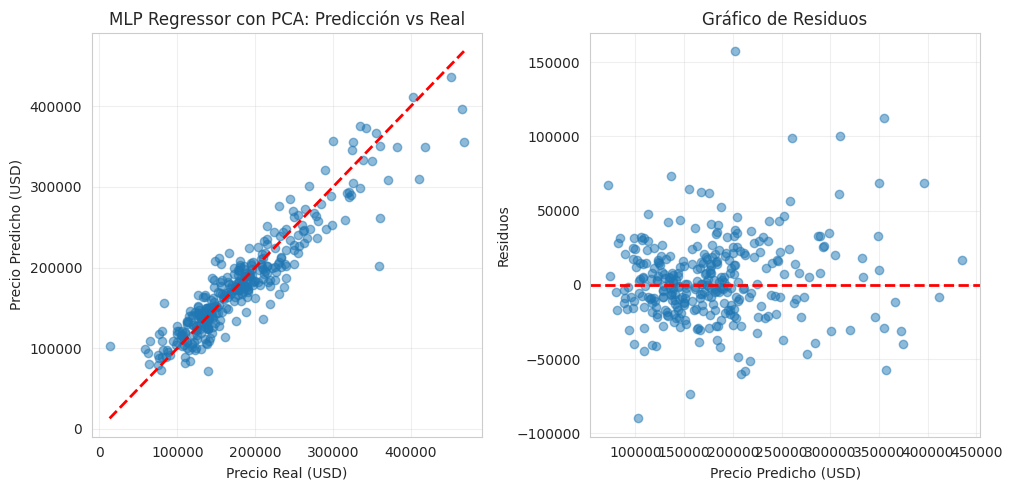

In [ ]:
print("MODELO 9 CON PCA: MLP REGRESSOR (RED NEURONAL)")
print("="*60)

param_grid_mlp_pca = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

mlp_pca = MLPRegressor(max_iter=1000, random_state=42)
grid_mlp_pca = GridSearchCV(mlp_pca, param_grid_mlp_pca, cv=5, scoring='r2', n_jobs=-1)
grid_mlp_pca.fit(X_train_pca, y_train)

best_mlp_pca = grid_mlp_pca.best_estimator_
print(f"Mejores parámetros: {grid_mlp_pca.best_params_}")

y_pred_mlp_pca_train = best_mlp_pca.predict(X_train_pca)
y_pred_mlp_pca_test = best_mlp_pca.predict(X_test_pca)

r2_train_mlp_pca = r2_score(y_train, y_pred_mlp_pca_train)
r2_test_mlp_pca = r2_score(y_test, y_pred_mlp_pca_test)
rmse_train_mlp_pca = np.sqrt(mean_squared_error(y_train, y_pred_mlp_pca_train))
rmse_test_mlp_pca = np.sqrt(mean_squared_error(y_test, y_pred_mlp_pca_test))
mse_test_mlp_pca = mean_squared_error(y_test, y_pred_mlp_pca_test)

cv_scores_mlp_pca = cross_val_score(best_mlp_pca, X_train_pca, y_train, cv=5, scoring='r2')

print(f"R² Entrenamiento: {r2_train_mlp_pca:.4f}")
print(f"R² Prueba: {r2_test_mlp_pca:.4f}")
print(f"RMSE Entrenamiento: {rmse_train_mlp_pca:.2f}")
print(f"RMSE Prueba: {rmse_test_mlp_pca:.2f}")
print(f"MSE Prueba: {mse_test_mlp_pca:.2f}")
print(f"Validación Cruzada R² (promedio): {cv_scores_mlp_pca.mean():.4f} (+/- {cv_scores_mlp_pca.std():.4f})")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_mlp_pca_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('MLP Regressor con PCA: Predicción vs Real')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
residuos = y_test - y_pred_mlp_pca_test
plt.scatter(y_pred_mlp_pca_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Precio Predicho (USD)')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('modelo9_pca_mlp_regressor.png', dpi=300, bbox_inches='tight')
plt.show()


#Tabla Comparativa de Todos los Modelos con PCA

In [ ]:
resultados_pca = {
    'Modelo': [
        'Regresión Lineal PCA',
        'Regresión Ridge PCA',
        'Regresión Lasso PCA',
        'Árbol de Decisión PCA',
        'Random Forest PCA',
        'Gradient Boosting PCA',
        'AdaBoost PCA',
        'SVR PCA',
        'MLP Regressor PCA'
    ],
    'R² Entrenamiento': [
        r2_train_lr_pca, r2_train_ridge_pca, r2_train_lasso_pca,
        r2_train_dt_pca, r2_train_rf_pca, r2_train_gb_pca,
        r2_train_ada_pca, r2_train_svr_pca, r2_train_mlp_pca
    ],
    'R² Prueba': [
        r2_test_lr_pca, r2_test_ridge_pca, r2_test_lasso_pca,
        r2_test_dt_pca, r2_test_rf_pca, r2_test_gb_pca,
        r2_test_ada_pca, r2_test_svr_pca, r2_test_mlp_pca
    ],
    'RMSE Entrenamiento': [
        rmse_train_lr_pca, rmse_train_ridge_pca, rmse_train_lasso_pca,
        rmse_train_dt_pca, rmse_train_rf_pca, rmse_train_gb_pca,
        rmse_train_ada_pca, rmse_train_svr_pca, rmse_train_mlp_pca
    ],
    'RMSE Prueba': [
        rmse_test_lr_pca, rmse_test_ridge_pca, rmse_test_lasso_pca,
        rmse_test_dt_pca, rmse_test_rf_pca, rmse_test_gb_pca,
        rmse_test_ada_pca, rmse_test_svr_pca, rmse_test_mlp_pca
    ],
    'MSE Prueba': [
        mse_test_lr_pca, mse_test_ridge_pca, mse_test_lasso_pca,
        mse_test_dt_pca, mse_test_rf_pca, mse_test_gb_pca,
        mse_test_ada_pca, mse_test_svr_pca, mse_test_mlp_pca
    ],
    'CV R² Promedio': [
        cv_scores_lr_pca.mean(), cv_scores_ridge_pca.mean(), cv_scores_lasso_pca.mean(),
        cv_scores_dt_pca.mean(), cv_scores_rf_pca.mean(), cv_scores_gb_pca.mean(),
        cv_scores_ada_pca.mean(), cv_scores_svr_pca.mean(), cv_scores_mlp_pca.mean()
    ]
}

df_resultados_pca = pd.DataFrame(resultados_pca)
df_resultados_pca = df_resultados_pca.sort_values('R² Prueba', ascending=False)

print("TABLA COMPARATIVA DE DESEMPEÑO DE MODELOS CON PCA")
print("="*100)
print(df_resultados_pca.to_string(index=False))

df_resultados_pca.to_csv('resultados_modelos_pca.csv', index=False)
print("\nTabla guardada como: resultados_modelos_pca.csv")


TABLA COMPARATIVA DE DESEMPEÑO DE MODELOS CON PCA
               Modelo  R² Entrenamiento  R² Prueba  RMSE Entrenamiento  RMSE Prueba   MSE Prueba  CV R² Promedio
    MLP Regressor PCA          0.931649   0.860335        19118.265758 27682.463190 7.663188e+08        0.851236
 Regresión Lineal PCA          0.880466   0.855691        25282.484179 28138.883609 7.917968e+08        0.843126
  Regresión Lasso PCA          0.880391   0.854610        25290.417090 28244.052787 7.977265e+08        0.869083
  Regresión Ridge PCA          0.880127   0.853543        25318.368309 28347.586136 8.035856e+08        0.870066
Gradient Boosting PCA          0.977214   0.849305        11038.431909 28754.805987 8.268389e+08        0.869836
    Random Forest PCA          0.978108   0.841766        10819.702723 29465.279327 8.682027e+08        0.865498
              SVR PCA          0.863178   0.829269        27049.130782 30606.728909 9.367719e+08        0.855565
Árbol de Decisión PCA          0.885953   0.81

#Comparación Final de Modelos Originales vs PCA


COMPARACIÓN COMPLETA: MODELOS ORIGINALES VS MODELOS CON PCA
                      Modelo  R² Prueba  RMSE Prueba   MSE Prueba
Gradient Boosting (Original)   0.892138 24327.366661 5.918208e+08
  Regresión Lasso (Original)   0.872868 26411.200143 6.975515e+08
 Regresión Lineal (Original)   0.872728 26425.694277 6.983173e+08
  Regresión Ridge (Original)   0.869532 26755.451488 7.158542e+08
    Random Forest (Original)   0.868198 26891.932828 7.231761e+08
         MLP Regressor (PCA)   0.860335 27682.463190 7.663188e+08
      Regresión Lineal (PCA)   0.855691 28138.883609 7.917968e+08
       Regresión Lasso (PCA)   0.854610 28244.052787 7.977265e+08
       Regresión Ridge (PCA)   0.853543 28347.586136 8.035856e+08
     Gradient Boosting (PCA)   0.849305 28754.805987 8.268389e+08
              SVR (Original)   0.841773 29464.631438 8.681645e+08
         Random Forest (PCA)   0.841766 29465.279327 8.682027e+08
                   SVR (PCA)   0.829269 30606.728909 9.367719e+08
         AdaBoo

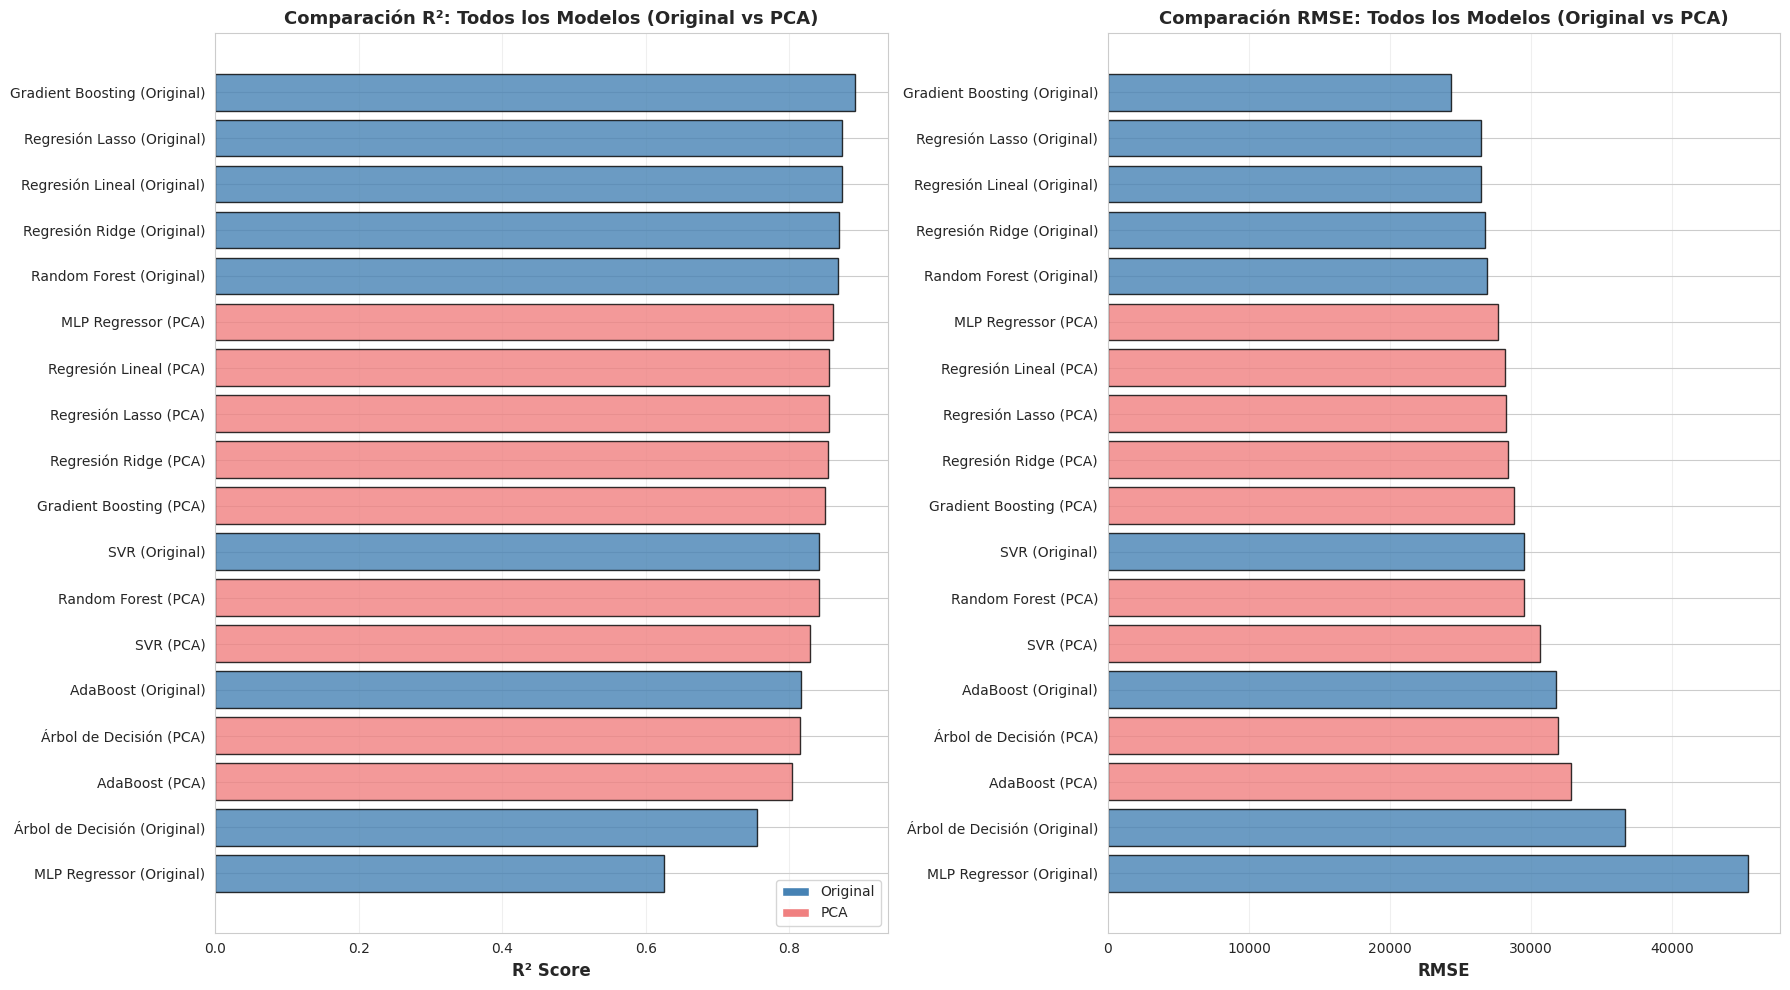


Gráfica de comparación completa guardada como: comparacion_completa_todos_modelos.png


In [ ]:
comparacion_completa = pd.DataFrame({
    'Modelo': [
        'Regresión Lineal (Original)',
        'Regresión Lineal (PCA)',
        'Regresión Ridge (Original)',
        'Regresión Ridge (PCA)',
        'Regresión Lasso (Original)',
        'Regresión Lasso (PCA)',
        'Árbol de Decisión (Original)',
        'Árbol de Decisión (PCA)',
        'Random Forest (Original)',
        'Random Forest (PCA)',
        'Gradient Boosting (Original)',
        'Gradient Boosting (PCA)',
        'AdaBoost (Original)',
        'AdaBoost (PCA)',
        'SVR (Original)',
        'SVR (PCA)',
        'MLP Regressor (Original)',
        'MLP Regressor (PCA)'
    ],
    'R² Prueba': [
        r2_test_lr, r2_test_lr_pca,
        r2_test_ridge, r2_test_ridge_pca,
        r2_test_lasso, r2_test_lasso_pca,
        r2_test_dt, r2_test_dt_pca,
        r2_test_rf, r2_test_rf_pca,
        r2_test_gb, r2_test_gb_pca,
        r2_test_ada, r2_test_ada_pca,
        r2_test_svr, r2_test_svr_pca,
        r2_test_mlp, r2_test_mlp_pca
    ],
    'RMSE Prueba': [
        rmse_test_lr, rmse_test_lr_pca,
        rmse_test_ridge, rmse_test_ridge_pca,
        rmse_test_lasso, rmse_test_lasso_pca,
        rmse_test_dt, rmse_test_dt_pca,
        rmse_test_rf, rmse_test_rf_pca,
        rmse_test_gb, rmse_test_gb_pca,
        rmse_test_ada, rmse_test_ada_pca,
        rmse_test_svr, rmse_test_svr_pca,
        rmse_test_mlp, rmse_test_mlp_pca
    ],
    'MSE Prueba': [
        mse_test_lr, mse_test_lr_pca,
        mse_test_ridge, mse_test_ridge_pca,
        mse_test_lasso, mse_test_lasso_pca,
        mse_test_dt, mse_test_dt_pca,
        mse_test_rf, mse_test_rf_pca,
        mse_test_gb, mse_test_gb_pca,
        mse_test_ada, mse_test_ada_pca,
        mse_test_svr, mse_test_svr_pca,
        mse_test_mlp, mse_test_mlp_pca
    ]
})

comparacion_completa = comparacion_completa.sort_values('R² Prueba', ascending=False)

print("\nCOMPARACIÓN COMPLETA: MODELOS ORIGINALES VS MODELOS CON PCA")
print("="*120)
print(comparacion_completa.to_string(index=False))

comparacion_completa.to_csv('comparacion_completa_original_vs_pca.csv', index=False)
print("\nTabla guardada como: comparacion_completa_original_vs_pca.csv")

fig, axes = plt.subplots(1, 2, figsize=(18, 10))

modelos_comp = comparacion_completa['Modelo'].tolist()
r2_comp = comparacion_completa['R² Prueba'].tolist()
rmse_comp = comparacion_completa['RMSE Prueba'].tolist()

colors = []
for modelo in modelos_comp:
    if 'PCA' in modelo:
        colors.append('lightcoral')
    else:
        colors.append('steelblue')

axes[0].barh(modelos_comp, r2_comp, color=colors, edgecolor='black', alpha=0.8)
axes[0].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación R²: Todos los Modelos (Original vs PCA)',
                  fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

axes[1].barh(modelos_comp, rmse_comp, color=colors, edgecolor='black', alpha=0.8)
axes[1].set_xlabel('RMSE', fontsize=12, fontweight='bold')
axes[1].set_title('Comparación RMSE: Todos los Modelos (Original vs PCA)',
                  fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='steelblue', label='Original'),
                   Patch(facecolor='lightcoral', label='PCA')]
axes[0].legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('comparacion_completa_todos_modelos.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfica de comparación completa guardada como: comparacion_completa_todos_modelos.png")
